In [ ]:
!pip install deepxde
!pip install numba
import deepxde as dde
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import cuda
from tensorflow.python.framework import ops


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# Set random seed
avg_uu = np.zeros((101, 2))
uu = np.zeros((101,2,100))

# Set hyperparameters
n_output = 2 # x, y

num_domain = 1000

n_adam = 2000

lr = 1e-3 # for Adam
loss_weights = [1., 0.01, 1., 1., 1., 1.]

# Set physical parameters
tmin, tmax = 0.0, 1.0 # normalized time

for seed in range(1, 101):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  dde.backend.tf.random.set_random_seed(seed)

  T = dde.Variable(1.0) # end time

  x0, y0 = 0., 1.
  x1, y1 = 1., 0.
  m0 = 1.
  g = 9.8

  def ode(t, u):
      x, y = u[:, 0:1], u[:, 1:2]
      x_T = dde.grad.jacobian(x, t) / T
      y_T = dde.grad.jacobian(y, t) / T
      ode1 = m0 * g * y0 - (m0 * g * y + 0.5 * m0 * (x_T ** 2 + y_T ** 2))
      ode2 = T * tf.ones_like(x)
      return [ode1, ode2]

  def sigmoid(x):
      return 1. / (1. + np.exp(-x))

  def sigmoid_tf(x, y):
      return 1. / (1. + tf.exp(-y))

  def boundary_left(t, on_boundary):
      return on_boundary * np.isclose(t[0], tmin)

  def boundary_right(t, on_boundary):
      return on_boundary * np.isclose(t[0], tmax)

  geom = dde.geometry.TimeDomain(tmin, tmax)
  bc0x = dde.icbc.DirichletBC(geom, lambda t: np.array([x0]), boundary_left, component=0)
  bc0y = dde.icbc.DirichletBC(geom, lambda t: np.array([y0]), boundary_left, component=1)
  bc1x = dde.icbc.DirichletBC(geom, lambda t: np.array([x1]), boundary_right, component=0)
  bc1y = dde.icbc.DirichletBC(geom, lambda t: np.array([y1]), boundary_right, component=1)
  data = dde.data.PDE(geom, ode, [bc0x, bc0y, bc1x, bc1y], num_domain=num_domain, num_boundary=2)

  net = dde.nn.FNN([1] + [64] * 3 + [n_output], "tanh", "Glorot normal")
  net.apply_output_transform(sigmoid_tf)

  resampler = dde.callbacks.PDEPointResampler(period=100)
  variable = dde.callbacks.VariableValue(T, period=10)
  ckpts = dde.callbacks.ModelCheckpoint('checkpoint', period=500)

  model = dde.Model(data, net)
  model.compile("adam", lr=lr, loss_weights=loss_weights, external_trainable_variables=T)
  losshistory, train_state = model.train(display_every=10, iterations=n_adam, callbacks=[resampler, variable, ckpts])
  model.compile("L-BFGS", loss_weights=loss_weights, external_trainable_variables=T)
  losshistory, train_state = model.train(display_every=10, callbacks=[resampler, variable, ckpts])


  t = np.linspace(tmin, tmax, 101)
  uu[:, :, seed-1] = model.predict(np.array([t]).T)

  ops.reset_default_graph()
  model = None
  net = None
  t = None
  resampler = None
  variable = None
  ckpts = None
  losshistory = None
  train_state = None
  timeVec = None
  bc0x = None
  bc0y = None
  bc1x = None
  data = None
  bc1y = None
  data = None
  ode1 = None
  ode2 = None
  del model, net, t, resampler, variable, ckpts, losshistory, train_state, timeVec, bc0x, bc0y, bc1x, data, bc1y, T

  print('dupa')
  print(seed)

Compiling model...
Building feed-forward neural network...
'build' took 0.073654 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.382306 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.68e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.81e-01, 1.97e-01]    [2.68e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.81e-01, 1.97e-01]    []  
0 [1.00e+00]
10        [7.84e+00, 9.80e-03, 2.64e-01, 1.83e-01, 2.88e-01, 6.94e-01]    [7.84e+00, 9.80e-03, 2.64e-01, 1.83e-01, 2.88e-01, 6.94e-01]    []  
10 [9.90e-01]
20        [1.75e+00, 9.59e-03, 2.85e-01, 1.03e-01, 1.80e-01, 9.44e-01]    [1.75e+00, 9.59e-03, 2.85e-01, 1.03e-01, 1.80e-01, 9.44e-01]    []  
20 [9.79e-01]
30        [4.13e-01, 9.38e-03, 3.26e-01, 4.59e-02, 7.68e-02, 9.87e-01]    [4.13e-01, 9.38e-03, 3.26e-01, 4.59e-02, 7.68e-02, 9.87e-01]    []  
30 [9.69e-01]
40        [1.34e-01, 9.22e-03, 3.72e-01, 2.24e-02, 3.12e-02, 9.95e-01]    [1.34e-01, 9.22e-03, 3.72e-01, 2.24e-02, 3.12e-02, 9.95e-01]    []  
40 [9.60e-01]
50        [6.47e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.737120 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.22e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.59e-01, 2.89e-01]    [2.22e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.59e-01, 2.89e-01]    []  
0 [1.00e+00]
10        [5.19e+00, 9.81e-03, 2.48e-01, 1.70e-01, 2.67e-01, 8.16e-01]    [5.19e+00, 9.81e-03, 2.48e-01, 1.70e-01, 2.67e-01, 8.16e-01]    []  
10 [9.90e-01]
20        [1.07e+00, 9.60e-03, 2.58e-01, 8.74e-02, 2.04e-01, 9.70e-01]    [1.07e+00, 9.60e-03, 2.58e-01, 8.74e-02, 2.04e-01, 9.70e-01]    []  
20 [9.80e-01]
30        [2.79e-01, 9.41e-03, 2.90e-01, 4.00e-02, 1.01e-01, 9.92e-01]    [2.79e-01, 9.41e-03, 2.90e-01, 4.00e-02, 1.01e-01, 9.92e-01]    []  
30 [9.70e-01]
40        [1.02e-01, 9.26e-03, 3.32e-01, 2.15e-02, 4.29e-02, 9.96e-01]    [1.02e-01, 9.26e-03, 3.32e-01, 2.15e-02, 4.29e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [5.15e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.813843 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.53e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.50e-01, 2.26e-01]    [2.53e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.50e-01, 2.26e-01]    []  
0 [1.00e+00]
10        [7.87e+00, 9.81e-03, 2.51e-01, 1.84e-01, 2.15e-01, 6.94e-01]    [7.87e+00, 9.81e-03, 2.51e-01, 1.84e-01, 2.15e-01, 6.94e-01]    []  
10 [9.91e-01]
20        [1.79e+00, 9.60e-03, 2.59e-01, 1.03e-01, 1.73e-01, 9.38e-01]    [1.79e+00, 9.60e-03, 2.59e-01, 1.03e-01, 1.73e-01, 9.38e-01]    []  
20 [9.80e-01]
30        [4.33e-01, 9.39e-03, 2.88e-01, 4.68e-02, 1.01e-01, 9.84e-01]    [4.33e-01, 9.39e-03, 2.88e-01, 4.68e-02, 1.01e-01, 9.84e-01]    []  
30 [9.69e-01]
40        [1.44e-01, 9.23e-03, 3.31e-01, 2.34e-02, 4.78e-02, 9.93e-01]    [1.44e-01, 9.23e-03, 3.31e-01, 2.34e-02, 4.78e-02, 9.93e-01]    []  
40 [9.61e-01]
50        [6.85e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.738244 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.80e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.02e-01, 1.78e-01]    [2.80e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.02e-01, 1.78e-01]    []  
0 [1.00e+00]
10        [9.00e+00, 9.81e-03, 2.58e-01, 1.85e-01, 1.43e-01, 6.43e-01]    [9.00e+00, 9.81e-03, 2.58e-01, 1.85e-01, 1.43e-01, 6.43e-01]    []  
10 [9.90e-01]
20        [2.09e+00, 9.59e-03, 2.79e-01, 1.07e-01, 8.66e-02, 9.26e-01]    [2.09e+00, 9.59e-03, 2.79e-01, 1.07e-01, 8.66e-02, 9.26e-01]    []  
20 [9.79e-01]
30        [4.67e-01, 9.38e-03, 3.22e-01, 4.79e-02, 4.10e-02, 9.84e-01]    [4.67e-01, 9.38e-03, 3.22e-01, 4.79e-02, 4.10e-02, 9.84e-01]    []  
30 [9.68e-01]
40        [1.43e-01, 9.20e-03, 3.61e-01, 2.32e-02, 2.20e-02, 9.94e-01]    [1.43e-01, 9.20e-03, 3.61e-01, 2.32e-02, 2.20e-02, 9.94e-01]    []  
40 [9.59e-01]
50        [6.75e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.742615 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.19e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.28e-01, 2.94e-01]    [2.19e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.28e-01, 2.94e-01]    []  
0 [1.00e+00]
10        [5.79e+00, 9.80e-03, 2.66e-01, 1.76e-01, 2.18e-01, 7.92e-01]    [5.79e+00, 9.80e-03, 2.66e-01, 1.76e-01, 2.18e-01, 7.92e-01]    []  
10 [9.90e-01]
20        [1.22e+00, 9.59e-03, 2.92e-01, 9.31e-02, 1.05e-01, 9.67e-01]    [1.22e+00, 9.59e-03, 2.92e-01, 9.31e-02, 1.05e-01, 9.67e-01]    []  
20 [9.79e-01]
30        [2.85e-01, 9.39e-03, 3.34e-01, 4.16e-02, 3.86e-02, 9.92e-01]    [2.85e-01, 9.39e-03, 3.34e-01, 4.16e-02, 3.86e-02, 9.92e-01]    []  
30 [9.69e-01]
40        [9.59e-02, 9.24e-03, 3.68e-01, 2.16e-02, 1.84e-02, 9.97e-01]    [9.59e-02, 9.24e-03, 3.68e-01, 2.16e-02, 1.84e-02, 9.97e-01]    []  
40 [9.61e-01]
50        [4.98e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.770408 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.80e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.44e-01, 1.79e-01]    [2.80e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.44e-01, 1.79e-01]    []  
0 [1.00e+00]
10        [7.77e+00, 9.80e-03, 2.32e-01, 1.88e-01, 4.59e-01, 6.98e-01]    [7.77e+00, 9.80e-03, 2.32e-01, 1.88e-01, 4.59e-01, 6.98e-01]    []  
10 [9.90e-01]
20        [1.84e+00, 9.59e-03, 2.17e-01, 1.16e-01, 4.92e-01, 9.41e-01]    [1.84e+00, 9.59e-03, 2.17e-01, 1.16e-01, 4.92e-01, 9.41e-01]    []  
20 [9.79e-01]
30        [5.17e-01, 9.38e-03, 2.24e-01, 5.97e-02, 3.61e-01, 9.84e-01]    [5.17e-01, 9.38e-03, 2.24e-01, 5.97e-02, 3.61e-01, 9.84e-01]    []  
30 [9.69e-01]
40        [2.04e-01, 9.22e-03, 2.64e-01, 3.18e-02, 1.63e-01, 9.93e-01]    [2.04e-01, 9.22e-03, 2.64e-01, 3.18e-02, 1.63e-01, 9.93e-01]    []  
40 [9.60e-01]
50        [9.66e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.760757 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.16e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.21e-01, 3.01e-01]    [2.16e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.21e-01, 3.01e-01]    []  
0 [1.00e+00]
10        [5.61e+00, 9.81e-03, 2.54e-01, 1.75e-01, 1.95e-01, 7.95e-01]    [5.61e+00, 9.81e-03, 2.54e-01, 1.75e-01, 1.95e-01, 7.95e-01]    []  
10 [9.90e-01]
20        [1.13e+00, 9.60e-03, 2.69e-01, 8.92e-02, 1.47e-01, 9.65e-01]    [1.13e+00, 9.60e-03, 2.69e-01, 8.92e-02, 1.47e-01, 9.65e-01]    []  
20 [9.80e-01]
30        [2.67e-01, 9.40e-03, 3.06e-01, 3.87e-02, 7.89e-02, 9.91e-01]    [2.67e-01, 9.40e-03, 3.06e-01, 3.87e-02, 7.89e-02, 9.91e-01]    []  
30 [9.70e-01]
40        [9.24e-02, 9.26e-03, 3.46e-01, 2.00e-02, 3.97e-02, 9.96e-01]    [9.24e-02, 9.26e-03, 3.46e-01, 2.00e-02, 3.97e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [4.69e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.227829 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.08e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.50e-01, 1.39e-01]    [3.08e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.50e-01, 1.39e-01]    []  
0 [1.00e+00]
10        [8.64e+00, 9.82e-03, 2.34e-01, 1.81e-01, 1.96e-01, 6.51e-01]    [8.64e+00, 9.82e-03, 2.34e-01, 1.81e-01, 1.96e-01, 6.51e-01]    []  
10 [9.91e-01]
20        [1.94e+00, 9.61e-03, 2.28e-01, 1.06e-01, 2.03e-01, 9.32e-01]    [1.94e+00, 9.61e-03, 2.28e-01, 1.06e-01, 2.03e-01, 9.32e-01]    []  
20 [9.80e-01]
30        [5.05e-01, 9.39e-03, 2.43e-01, 5.17e-02, 1.46e-01, 9.84e-01]    [5.05e-01, 9.39e-03, 2.43e-01, 5.17e-02, 1.46e-01, 9.84e-01]    []  
30 [9.69e-01]
40        [1.80e-01, 9.22e-03, 2.75e-01, 2.72e-02, 7.73e-02, 9.93e-01]    [1.80e-01, 9.22e-03, 2.75e-01, 2.72e-02, 7.73e-02, 9.93e-01]    []  
40 [9.60e-01]
50        [8.47e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.763219 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.28e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.29e-01, 2.76e-01]    [2.28e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.29e-01, 2.76e-01]    []  
0 [1.00e+00]
10        [6.53e+00, 9.81e-03, 2.43e-01, 1.73e-01, 2.32e-01, 7.50e-01]    [6.53e+00, 9.81e-03, 2.43e-01, 1.73e-01, 2.32e-01, 7.50e-01]    []  
10 [9.90e-01]
20        [1.33e+00, 9.60e-03, 2.55e-01, 8.52e-02, 1.64e-01, 9.57e-01]    [1.33e+00, 9.60e-03, 2.55e-01, 8.52e-02, 1.64e-01, 9.57e-01]    []  
20 [9.80e-01]
30        [2.93e-01, 9.40e-03, 2.95e-01, 3.36e-02, 7.56e-02, 9.90e-01]    [2.93e-01, 9.40e-03, 2.95e-01, 3.36e-02, 7.56e-02, 9.90e-01]    []  
30 [9.70e-01]
40        [9.30e-02, 9.26e-03, 3.39e-01, 1.57e-02, 3.42e-02, 9.96e-01]    [9.30e-02, 9.26e-03, 3.39e-01, 1.57e-02, 3.42e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [4.58e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.745774 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.63e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.72e-01, 2.07e-01]    [2.63e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.72e-01, 2.07e-01]    []  
0 [1.00e+00]
10        [6.18e+00, 9.81e-03, 2.49e-01, 1.73e-01, 2.41e-01, 7.62e-01]    [6.18e+00, 9.81e-03, 2.49e-01, 1.73e-01, 2.41e-01, 7.62e-01]    []  
10 [9.91e-01]
20        [1.22e+00, 9.60e-03, 2.61e-01, 9.24e-02, 1.52e-01, 9.63e-01]    [1.22e+00, 9.60e-03, 2.61e-01, 9.24e-02, 1.52e-01, 9.63e-01]    []  
20 [9.80e-01]
30        [2.97e-01, 9.40e-03, 2.97e-01, 4.36e-02, 6.04e-02, 9.90e-01]    [2.97e-01, 9.40e-03, 2.97e-01, 4.36e-02, 6.04e-02, 9.90e-01]    []  
30 [9.70e-01]
40        [1.00e-01, 9.24e-03, 3.36e-01, 2.41e-02, 2.44e-02, 9.96e-01]    [1.00e-01, 9.24e-03, 3.36e-01, 2.41e-02, 2.44e-02, 9.96e-01]    []  
40 [9.61e-01]
50        [4.91e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.141025 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.33e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.91e-01, 2.64e-01]    [2.33e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.91e-01, 2.64e-01]    []  
0 [1.00e+00]
10        [4.71e+00, 9.81e-03, 2.52e-01, 1.63e-01, 1.64e-01, 8.30e-01]    [4.71e+00, 9.81e-03, 2.52e-01, 1.63e-01, 1.64e-01, 8.30e-01]    []  
10 [9.90e-01]
20        [9.78e-01, 9.60e-03, 2.67e-01, 8.32e-02, 1.01e-01, 9.72e-01]    [9.78e-01, 9.60e-03, 2.67e-01, 8.32e-02, 1.01e-01, 9.72e-01]    []  
20 [9.80e-01]
30        [2.55e-01, 9.40e-03, 2.99e-01, 3.94e-02, 4.44e-02, 9.92e-01]    [2.55e-01, 9.40e-03, 2.99e-01, 3.94e-02, 4.44e-02, 9.92e-01]    []  
30 [9.70e-01]
40        [9.36e-02, 9.26e-03, 3.28e-01, 2.22e-02, 2.20e-02, 9.96e-01]    [9.36e-02, 9.26e-03, 3.28e-01, 2.22e-02, 2.20e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [4.91e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.740985 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.20e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.07e-01, 2.96e-01]    [2.20e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.07e-01, 2.96e-01]    []  
0 [1.00e+00]
10        [4.81e+00, 9.81e-03, 2.52e-01, 1.75e-01, 1.66e-01, 8.41e-01]    [4.81e+00, 9.81e-03, 2.52e-01, 1.75e-01, 1.66e-01, 8.41e-01]    []  
10 [9.90e-01]
20        [9.66e-01, 9.60e-03, 2.70e-01, 9.37e-02, 8.53e-02, 9.78e-01]    [9.66e-01, 9.60e-03, 2.70e-01, 9.37e-02, 8.53e-02, 9.78e-01]    []  
20 [9.80e-01]
30        [2.26e-01, 9.40e-03, 3.07e-01, 4.51e-02, 3.00e-02, 9.94e-01]    [2.26e-01, 9.40e-03, 3.07e-01, 4.51e-02, 3.00e-02, 9.94e-01]    []  
30 [9.70e-01]
40        [7.36e-02, 9.25e-03, 3.36e-01, 2.59e-02, 1.35e-02, 9.97e-01]    [7.36e-02, 9.25e-03, 3.36e-01, 2.59e-02, 1.35e-02, 9.97e-01]    []  
40 [9.62e-01]
50        [3.60e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.046895 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.59e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.20e-01, 2.13e-01]    [2.59e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.20e-01, 2.13e-01]    []  
0 [1.00e+00]
10        [6.71e+00, 9.81e-03, 2.69e-01, 1.84e-01, 9.81e-02, 7.42e-01]    [6.71e+00, 9.81e-03, 2.69e-01, 1.84e-01, 9.81e-02, 7.42e-01]    []  
10 [9.90e-01]
20        [1.57e+00, 9.60e-03, 3.06e-01, 1.11e-01, 3.23e-02, 9.48e-01]    [1.57e+00, 9.60e-03, 3.06e-01, 1.11e-01, 3.23e-02, 9.48e-01]    []  
20 [9.80e-01]
30        [3.92e-01, 9.39e-03, 3.59e-01, 5.97e-02, 9.61e-03, 9.85e-01]    [3.92e-01, 9.39e-03, 3.59e-01, 5.97e-02, 9.61e-03, 9.85e-01]    []  
30 [9.69e-01]
40        [1.32e-01, 9.21e-03, 3.94e-01, 3.56e-02, 4.79e-03, 9.93e-01]    [1.32e-01, 9.21e-03, 3.94e-01, 3.56e-02, 4.79e-03, 9.93e-01]    []  
40 [9.60e-01]
50        [6.52e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.817634 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.03e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.43e-01, 3.33e-01]    [2.03e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.43e-01, 3.33e-01]    []  
0 [1.00e+00]
10        [5.41e+00, 9.80e-03, 2.51e-01, 1.75e-01, 1.97e-01, 8.07e-01]    [5.41e+00, 9.80e-03, 2.51e-01, 1.75e-01, 1.97e-01, 8.07e-01]    []  
10 [9.90e-01]
20        [1.11e+00, 9.59e-03, 2.68e-01, 8.84e-02, 1.13e-01, 9.68e-01]    [1.11e+00, 9.59e-03, 2.68e-01, 8.84e-02, 1.13e-01, 9.68e-01]    []  
20 [9.79e-01]
30        [2.45e-01, 9.40e-03, 3.08e-01, 3.74e-02, 4.47e-02, 9.92e-01]    [2.45e-01, 9.40e-03, 3.08e-01, 3.74e-02, 4.47e-02, 9.92e-01]    []  
30 [9.70e-01]
40        [7.77e-02, 9.26e-03, 3.42e-01, 1.89e-02, 2.12e-02, 9.97e-01]    [7.77e-02, 9.26e-03, 3.42e-01, 1.89e-02, 2.12e-02, 9.97e-01]    []  
40 [9.62e-01]
50        [3.84e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.746364 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.60e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.98e-01, 2.12e-01]    [2.60e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.98e-01, 2.12e-01]    []  
0 [1.00e+00]
10        [8.49e+00, 9.80e-03, 2.61e-01, 1.92e-01, 1.13e-01, 6.67e-01]    [8.49e+00, 9.80e-03, 2.61e-01, 1.92e-01, 1.13e-01, 6.67e-01]    []  
10 [9.90e-01]
20        [2.11e+00, 9.59e-03, 2.87e-01, 1.19e-01, 5.31e-02, 9.21e-01]    [2.11e+00, 9.59e-03, 2.87e-01, 1.19e-01, 5.31e-02, 9.21e-01]    []  
20 [9.79e-01]
30        [4.99e-01, 9.38e-03, 3.35e-01, 6.00e-02, 2.08e-02, 9.78e-01]    [4.99e-01, 9.38e-03, 3.35e-01, 6.00e-02, 2.08e-02, 9.78e-01]    []  
30 [9.68e-01]
40        [1.54e-01, 9.19e-03, 3.75e-01, 3.23e-02, 1.06e-02, 9.90e-01]    [1.54e-01, 9.19e-03, 3.75e-01, 3.23e-02, 1.06e-02, 9.90e-01]    []  
40 [9.59e-01]
50        [7.13e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.739689 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.58e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.74e-01, 2.17e-01]    [2.58e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.74e-01, 2.17e-01]    []  
0 [1.00e+00]
10        [6.90e+00, 9.81e-03, 2.52e-01, 1.75e-01, 2.43e-01, 7.34e-01]    [6.90e+00, 9.81e-03, 2.52e-01, 1.75e-01, 2.43e-01, 7.34e-01]    []  
10 [9.91e-01]
20        [1.59e+00, 9.60e-03, 2.62e-01, 9.72e-02, 1.76e-01, 9.49e-01]    [1.59e+00, 9.60e-03, 2.62e-01, 9.72e-02, 1.76e-01, 9.49e-01]    []  
20 [9.80e-01]
30        [4.21e-01, 9.40e-03, 2.90e-01, 4.58e-02, 9.18e-02, 9.87e-01]    [4.21e-01, 9.40e-03, 2.90e-01, 4.58e-02, 9.18e-02, 9.87e-01]    []  
30 [9.69e-01]
40        [1.51e-01, 9.23e-03, 3.26e-01, 2.40e-02, 4.26e-02, 9.94e-01]    [1.51e-01, 9.23e-03, 3.26e-01, 2.40e-02, 4.26e-02, 9.94e-01]    []  
40 [9.61e-01]
50        [7.51e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.754544 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.38e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.13e-01, 2.52e-01]    [2.38e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.13e-01, 2.52e-01]    []  
0 [1.00e+00]
10        [5.48e+00, 9.81e-03, 2.46e-01, 1.76e-01, 3.28e-01, 8.04e-01]    [5.48e+00, 9.81e-03, 2.46e-01, 1.76e-01, 3.28e-01, 8.04e-01]    []  
10 [9.90e-01]
20        [1.23e+00, 9.60e-03, 2.53e-01, 9.97e-02, 2.55e-01, 9.68e-01]    [1.23e+00, 9.60e-03, 2.53e-01, 9.97e-02, 2.55e-01, 9.68e-01]    []  
20 [9.80e-01]
30        [3.43e-01, 9.40e-03, 2.79e-01, 4.94e-02, 1.35e-01, 9.92e-01]    [3.43e-01, 9.40e-03, 2.79e-01, 4.94e-02, 1.35e-01, 9.92e-01]    []  
30 [9.69e-01]
40        [1.30e-01, 9.25e-03, 3.15e-01, 2.73e-02, 5.82e-02, 9.96e-01]    [1.30e-01, 9.25e-03, 3.15e-01, 2.73e-02, 5.82e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [6.46e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.765400 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.76e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.88e-01, 1.84e-01]    [2.76e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.88e-01, 1.84e-01]    []  
0 [1.00e+00]
10        [5.89e+00, 9.81e-03, 2.57e-01, 1.77e-01, 1.03e-01, 7.72e-01]    [5.89e+00, 9.81e-03, 2.57e-01, 1.77e-01, 1.03e-01, 7.72e-01]    []  
10 [9.90e-01]
20        [1.16e+00, 9.59e-03, 2.80e-01, 9.86e-02, 4.26e-02, 9.63e-01]    [1.16e+00, 9.59e-03, 2.80e-01, 9.86e-02, 4.26e-02, 9.63e-01]    []  
20 [9.80e-01]
30        [2.69e-01, 9.39e-03, 3.17e-01, 4.95e-02, 1.64e-02, 9.90e-01]    [2.69e-01, 9.39e-03, 3.17e-01, 4.95e-02, 1.64e-02, 9.90e-01]    []  
30 [9.69e-01]
40        [8.85e-02, 9.22e-03, 3.38e-01, 2.92e-02, 9.21e-03, 9.95e-01]    [8.85e-02, 9.22e-03, 3.38e-01, 2.92e-02, 9.21e-03, 9.95e-01]    []  
40 [9.60e-01]
50        [4.29e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.769612 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.51e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.35e-01, 2.28e-01]    [2.51e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.35e-01, 2.28e-01]    []  
0 [1.00e+00]
10        [7.10e+00, 9.80e-03, 2.46e-01, 1.82e-01, 1.27e-01, 7.21e-01]    [7.10e+00, 9.80e-03, 2.46e-01, 1.82e-01, 1.27e-01, 7.21e-01]    []  
10 [9.90e-01]
20        [1.56e+00, 9.59e-03, 2.58e-01, 9.94e-02, 9.93e-02, 9.44e-01]    [1.56e+00, 9.59e-03, 2.58e-01, 9.94e-02, 9.93e-02, 9.44e-01]    []  
20 [9.79e-01]
30        [3.67e-01, 9.38e-03, 2.89e-01, 4.43e-02, 6.01e-02, 9.85e-01]    [3.67e-01, 9.38e-03, 2.89e-01, 4.43e-02, 6.01e-02, 9.85e-01]    []  
30 [9.69e-01]
40        [1.22e-01, 9.23e-03, 3.23e-01, 2.23e-02, 3.50e-02, 9.93e-01]    [1.22e-01, 9.23e-03, 3.23e-01, 2.23e-02, 3.50e-02, 9.93e-01]    []  
40 [9.61e-01]
50        [5.91e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.749879 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.36e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.74e-01, 2.59e-01]    [2.36e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.74e-01, 2.59e-01]    []  
0 [1.00e+00]
10        [5.45e+00, 9.80e-03, 2.56e-01, 1.76e-01, 1.29e-01, 8.06e-01]    [5.45e+00, 9.80e-03, 2.56e-01, 1.76e-01, 1.29e-01, 8.06e-01]    []  
10 [9.90e-01]
20        [1.12e+00, 9.59e-03, 2.72e-01, 9.47e-02, 8.50e-02, 9.70e-01]    [1.12e+00, 9.59e-03, 2.72e-01, 9.47e-02, 8.50e-02, 9.70e-01]    []  
20 [9.79e-01]
30        [2.74e-01, 9.40e-03, 3.03e-01, 4.44e-02, 4.79e-02, 9.92e-01]    [2.74e-01, 9.40e-03, 3.03e-01, 4.44e-02, 4.79e-02, 9.92e-01]    []  
30 [9.69e-01]
40        [9.69e-02, 9.25e-03, 3.32e-01, 2.44e-02, 2.87e-02, 9.96e-01]    [9.69e-02, 9.25e-03, 3.32e-01, 2.44e-02, 2.87e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [4.97e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.071776 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.39e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.57e-01, 2.52e-01]    [2.39e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.57e-01, 2.52e-01]    []  
0 [1.00e+00]
10        [6.75e+00, 9.81e-03, 2.44e-01, 1.77e-01, 2.71e-01, 7.39e-01]    [6.75e+00, 9.81e-03, 2.44e-01, 1.77e-01, 2.71e-01, 7.39e-01]    []  
10 [9.91e-01]
20        [1.49e+00, 9.60e-03, 2.46e-01, 9.45e-02, 2.63e-01, 9.49e-01]    [1.49e+00, 9.60e-03, 2.46e-01, 9.45e-02, 2.63e-01, 9.49e-01]    []  
20 [9.80e-01]
30        [3.80e-01, 9.40e-03, 2.69e-01, 4.18e-02, 1.85e-01, 9.87e-01]    [3.80e-01, 9.40e-03, 2.69e-01, 4.18e-02, 1.85e-01, 9.87e-01]    []  
30 [9.70e-01]
40        [1.39e-01, 9.25e-03, 3.10e-01, 2.10e-02, 9.51e-02, 9.94e-01]    [1.39e-01, 9.25e-03, 3.10e-01, 2.10e-02, 9.51e-02, 9.94e-01]    []  
40 [9.62e-01]
50        [6.84e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.810266 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.58e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.47e-01, 2.16e-01]    [2.58e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.47e-01, 2.16e-01]    []  
0 [1.00e+00]
10        [7.10e+00, 9.80e-03, 2.44e-01, 1.84e-01, 1.45e-01, 7.27e-01]    [7.10e+00, 9.80e-03, 2.44e-01, 1.84e-01, 1.45e-01, 7.27e-01]    []  
10 [9.90e-01]
20        [1.48e+00, 9.59e-03, 2.59e-01, 1.07e-01, 8.24e-02, 9.53e-01]    [1.48e+00, 9.59e-03, 2.59e-01, 1.07e-01, 8.24e-02, 9.53e-01]    []  
20 [9.79e-01]
30        [3.32e-01, 9.37e-03, 2.97e-01, 5.33e-02, 2.90e-02, 9.88e-01]    [3.32e-01, 9.37e-03, 2.97e-01, 5.33e-02, 2.90e-02, 9.88e-01]    []  
30 [9.68e-01]
40        [9.84e-02, 9.20e-03, 3.31e-01, 3.02e-02, 1.20e-02, 9.94e-01]    [9.84e-02, 9.20e-03, 3.31e-01, 3.02e-02, 1.20e-02, 9.94e-01]    []  
40 [9.59e-01]
50        [4.26e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.799167 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.15e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.87e-01, 3.03e-01]    [2.15e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.87e-01, 3.03e-01]    []  
0 [1.00e+00]
10        [4.99e+00, 9.80e-03, 2.51e-01, 1.70e-01, 1.52e-01, 8.20e-01]    [4.99e+00, 9.80e-03, 2.51e-01, 1.70e-01, 1.52e-01, 8.20e-01]    []  
10 [9.90e-01]
20        [1.02e+00, 9.59e-03, 2.67e-01, 8.85e-02, 9.34e-02, 9.70e-01]    [1.02e+00, 9.59e-03, 2.67e-01, 8.85e-02, 9.34e-02, 9.70e-01]    []  
20 [9.79e-01]
30        [2.51e-01, 9.40e-03, 3.01e-01, 4.20e-02, 4.49e-02, 9.92e-01]    [2.51e-01, 9.40e-03, 3.01e-01, 4.20e-02, 4.49e-02, 9.92e-01]    []  
30 [9.69e-01]
40        [8.86e-02, 9.25e-03, 3.30e-01, 2.37e-02, 2.42e-02, 9.96e-01]    [8.86e-02, 9.25e-03, 3.30e-01, 2.37e-02, 2.42e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [4.51e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.830511 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.82e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.10e-01, 1.76e-01]    [2.82e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.10e-01, 1.76e-01]    []  
0 [1.00e+00]
10        [8.21e+00, 9.82e-03, 2.27e-01, 1.82e-01, 3.29e-01, 6.71e-01]    [8.21e+00, 9.82e-03, 2.27e-01, 1.82e-01, 3.29e-01, 6.71e-01]    []  
10 [9.91e-01]
20        [1.78e+00, 9.61e-03, 2.13e-01, 1.02e-01, 3.67e-01, 9.37e-01]    [1.78e+00, 9.61e-03, 2.13e-01, 1.02e-01, 3.67e-01, 9.37e-01]    []  
20 [9.80e-01]
30        [4.47e-01, 9.40e-03, 2.29e-01, 4.66e-02, 2.40e-01, 9.85e-01]    [4.47e-01, 9.40e-03, 2.29e-01, 4.66e-02, 2.40e-01, 9.85e-01]    []  
30 [9.70e-01]
40        [1.57e-01, 9.24e-03, 2.77e-01, 2.34e-02, 8.74e-02, 9.93e-01]    [1.57e-01, 9.24e-03, 2.77e-01, 2.34e-02, 8.74e-02, 9.93e-01]    []  
40 [9.61e-01]
50        [6.93e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.799052 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.01e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.64e-01, 3.39e-01]    [2.01e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.64e-01, 3.39e-01]    []  
0 [1.00e+00]
10        [6.10e+00, 9.80e-03, 2.63e-01, 1.81e-01, 2.72e-01, 7.77e-01]    [6.10e+00, 9.80e-03, 2.63e-01, 1.81e-01, 2.72e-01, 7.77e-01]    []  
10 [9.90e-01]
20        [1.25e+00, 9.59e-03, 2.99e-01, 9.22e-02, 1.17e-01, 9.59e-01]    [1.25e+00, 9.59e-03, 2.99e-01, 9.22e-02, 1.17e-01, 9.59e-01]    []  
20 [9.79e-01]
30        [2.58e-01, 9.39e-03, 3.64e-01, 3.76e-02, 2.90e-02, 9.90e-01]    [2.58e-01, 9.39e-03, 3.64e-01, 3.76e-02, 2.90e-02, 9.90e-01]    []  
30 [9.69e-01]
40        [7.92e-02, 9.25e-03, 4.05e-01, 1.84e-02, 1.24e-02, 9.95e-01]    [7.92e-02, 9.25e-03, 4.05e-01, 1.84e-02, 1.24e-02, 9.95e-01]    []  
40 [9.62e-01]
50        [4.17e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.689970 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.26e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.47e-01, 2.81e-01]    [2.26e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.47e-01, 2.81e-01]    []  
0 [1.00e+00]
10        [6.44e+00, 9.81e-03, 2.42e-01, 1.79e-01, 2.73e-01, 7.61e-01]    [6.44e+00, 9.81e-03, 2.42e-01, 1.79e-01, 2.73e-01, 7.61e-01]    []  
10 [9.90e-01]
20        [1.50e+00, 9.60e-03, 2.47e-01, 9.73e-02, 2.24e-01, 9.53e-01]    [1.50e+00, 9.60e-03, 2.47e-01, 9.73e-02, 2.24e-01, 9.53e-01]    []  
20 [9.80e-01]
30        [3.86e-01, 9.40e-03, 2.76e-01, 4.36e-02, 1.16e-01, 9.88e-01]    [3.86e-01, 9.40e-03, 2.76e-01, 4.36e-02, 1.16e-01, 9.88e-01]    []  
30 [9.70e-01]
40        [1.33e-01, 9.25e-03, 3.20e-01, 2.16e-02, 4.67e-02, 9.94e-01]    [1.33e-01, 9.25e-03, 3.20e-01, 2.16e-02, 4.67e-02, 9.94e-01]    []  
40 [9.62e-01]
50        [6.29e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.787516 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.44e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.52e-01, 2.44e-01]    [2.44e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.52e-01, 2.44e-01]    []  
0 [1.00e+00]
10        [7.24e+00, 9.80e-03, 2.67e-01, 1.83e-01, 2.31e-01, 7.27e-01]    [7.24e+00, 9.80e-03, 2.67e-01, 1.83e-01, 2.31e-01, 7.27e-01]    []  
10 [9.90e-01]
20        [1.60e+00, 9.59e-03, 3.01e-01, 1.01e-01, 9.23e-02, 9.49e-01]    [1.60e+00, 9.59e-03, 3.01e-01, 1.01e-01, 9.23e-02, 9.49e-01]    []  
20 [9.79e-01]
30        [3.64e-01, 9.38e-03, 3.59e-01, 4.57e-02, 2.42e-02, 9.88e-01]    [3.64e-01, 9.38e-03, 3.59e-01, 4.57e-02, 2.42e-02, 9.88e-01]    []  
30 [9.68e-01]
40        [1.18e-01, 9.21e-03, 4.00e-01, 2.37e-02, 1.03e-02, 9.95e-01]    [1.18e-01, 9.21e-03, 4.00e-01, 2.37e-02, 1.03e-02, 9.95e-01]    []  
40 [9.60e-01]
50        [6.12e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.785697 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.61e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.81e-01, 2.11e-01]    [2.61e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.81e-01, 2.11e-01]    []  
0 [1.00e+00]
10        [7.00e+00, 9.80e-03, 2.36e-01, 1.81e-01, 2.25e-01, 7.31e-01]    [7.00e+00, 9.80e-03, 2.36e-01, 1.81e-01, 2.25e-01, 7.31e-01]    []  
10 [9.90e-01]
20        [1.62e+00, 9.59e-03, 2.30e-01, 1.04e-01, 2.09e-01, 9.47e-01]    [1.62e+00, 9.59e-03, 2.30e-01, 1.04e-01, 2.09e-01, 9.47e-01]    []  
20 [9.79e-01]
30        [4.35e-01, 9.39e-03, 2.44e-01, 5.04e-02, 1.31e-01, 9.85e-01]    [4.35e-01, 9.39e-03, 2.44e-01, 5.04e-02, 1.31e-01, 9.85e-01]    []  
30 [9.69e-01]
40        [1.57e-01, 9.22e-03, 2.74e-01, 2.68e-02, 6.38e-02, 9.93e-01]    [1.57e-01, 9.22e-03, 2.74e-01, 2.68e-02, 6.38e-02, 9.93e-01]    []  
40 [9.60e-01]
50        [7.35e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.768490 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.73e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.64e-01, 4.13e-01]    [1.73e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.64e-01, 4.13e-01]    []  
0 [1.00e+00]
10        [3.64e+00, 9.80e-03, 2.43e-01, 1.60e-01, 2.80e-01, 8.86e-01]    [3.64e+00, 9.80e-03, 2.43e-01, 1.60e-01, 2.80e-01, 8.86e-01]    []  
10 [9.90e-01]
20        [7.27e-01, 9.60e-03, 2.52e-01, 7.44e-02, 2.05e-01, 9.82e-01]    [7.27e-01, 9.60e-03, 2.52e-01, 7.44e-02, 2.05e-01, 9.82e-01]    []  
20 [9.80e-01]
30        [1.87e-01, 9.42e-03, 2.89e-01, 3.20e-02, 8.59e-02, 9.95e-01]    [1.87e-01, 9.42e-03, 2.89e-01, 3.20e-02, 8.59e-02, 9.95e-01]    []  
30 [9.71e-01]
40        [6.65e-02, 9.31e-03, 3.29e-01, 1.72e-02, 3.25e-02, 9.97e-01]    [6.65e-02, 9.31e-03, 3.29e-01, 1.72e-02, 3.25e-02, 9.97e-01]    []  
40 [9.65e-01]
50        [3.33e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.780474 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.51e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.24e-01, 2.29e-01]    [2.51e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.24e-01, 2.29e-01]    []  
0 [1.00e+00]
10        [7.23e+00, 9.81e-03, 2.66e-01, 1.83e-01, 1.12e-01, 7.20e-01]    [7.23e+00, 9.81e-03, 2.66e-01, 1.83e-01, 1.12e-01, 7.20e-01]    []  
10 [9.90e-01]
20        [1.67e+00, 9.60e-03, 3.00e-01, 1.05e-01, 4.33e-02, 9.43e-01]    [1.67e+00, 9.60e-03, 3.00e-01, 1.05e-01, 4.33e-02, 9.43e-01]    []  
20 [9.80e-01]
30        [3.87e-01, 9.39e-03, 3.50e-01, 4.96e-02, 1.59e-02, 9.86e-01]    [3.87e-01, 9.39e-03, 3.50e-01, 4.96e-02, 1.59e-02, 9.86e-01]    []  
30 [9.69e-01]
40        [1.24e-01, 9.22e-03, 3.83e-01, 2.62e-02, 9.29e-03, 9.94e-01]    [1.24e-01, 9.22e-03, 3.83e-01, 2.62e-02, 9.29e-03, 9.94e-01]    []  
40 [9.60e-01]
50        [6.16e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.762863 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.47e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.53e-01, 2.37e-01]    [2.47e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.53e-01, 2.37e-01]    []  
0 [1.00e+00]
10        [6.75e+00, 9.81e-03, 2.47e-01, 1.82e-01, 2.14e-01, 7.48e-01]    [6.75e+00, 9.81e-03, 2.47e-01, 1.82e-01, 2.14e-01, 7.48e-01]    []  
10 [9.91e-01]
20        [1.44e+00, 9.60e-03, 2.56e-01, 1.01e-01, 1.47e-01, 9.58e-01]    [1.44e+00, 9.60e-03, 2.56e-01, 1.01e-01, 1.47e-01, 9.58e-01]    []  
20 [9.80e-01]
30        [3.39e-01, 9.40e-03, 2.88e-01, 4.64e-02, 7.04e-02, 9.90e-01]    [3.39e-01, 9.40e-03, 2.88e-01, 4.64e-02, 7.04e-02, 9.90e-01]    []  
30 [9.69e-01]
40        [1.10e-01, 9.23e-03, 3.27e-01, 2.41e-02, 3.22e-02, 9.96e-01]    [1.10e-01, 9.23e-03, 3.27e-01, 2.41e-02, 3.22e-02, 9.96e-01]    []  
40 [9.61e-01]
50        [5.18e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.779370 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.23e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.82e-01, 2.87e-01]    [2.23e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.82e-01, 2.87e-01]    []  
0 [1.00e+00]
10        [4.64e+00, 9.80e-03, 2.61e-01, 1.68e-01, 1.15e-01, 8.39e-01]    [4.64e+00, 9.80e-03, 2.61e-01, 1.68e-01, 1.15e-01, 8.39e-01]    []  
10 [9.90e-01]
20        [8.64e-01, 9.59e-03, 2.92e-01, 8.43e-02, 4.81e-02, 9.77e-01]    [8.64e-01, 9.59e-03, 2.92e-01, 8.43e-02, 4.81e-02, 9.77e-01]    []  
20 [9.80e-01]
30        [1.95e-01, 9.40e-03, 3.36e-01, 3.91e-02, 1.80e-02, 9.94e-01]    [1.95e-01, 9.40e-03, 3.36e-01, 3.91e-02, 1.80e-02, 9.94e-01]    []  
30 [9.70e-01]
40        [6.72e-02, 9.26e-03, 3.62e-01, 2.25e-02, 1.05e-02, 9.97e-01]    [6.72e-02, 9.26e-03, 3.62e-01, 2.25e-02, 1.05e-02, 9.97e-01]    []  
40 [9.62e-01]
50        [3.67e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.783005 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.66e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.61e-01, 2.01e-01]    [2.66e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.61e-01, 2.01e-01]    []  
0 [1.00e+00]
10        [6.46e+00, 9.80e-03, 2.40e-01, 1.75e-01, 3.66e-01, 7.51e-01]    [6.46e+00, 9.80e-03, 2.40e-01, 1.75e-01, 3.66e-01, 7.51e-01]    []  
10 [9.90e-01]
20        [1.42e+00, 9.59e-03, 2.44e-01, 9.47e-02, 2.84e-01, 9.54e-01]    [1.42e+00, 9.59e-03, 2.44e-01, 9.47e-02, 2.84e-01, 9.54e-01]    []  
20 [9.79e-01]
30        [3.87e-01, 9.39e-03, 2.74e-01, 4.41e-02, 1.45e-01, 9.88e-01]    [3.87e-01, 9.39e-03, 2.74e-01, 4.41e-02, 1.45e-01, 9.88e-01]    []  
30 [9.69e-01]
40        [1.44e-01, 9.24e-03, 3.19e-01, 2.31e-02, 5.92e-02, 9.94e-01]    [1.44e-01, 9.24e-03, 3.19e-01, 2.31e-02, 5.92e-02, 9.94e-01]    []  
40 [9.61e-01]
50        [7.22e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.769200 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.80e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.27e-01, 1.80e-01]    [2.80e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.27e-01, 1.80e-01]    []  
0 [1.00e+00]
10        [5.78e+00, 9.82e-03, 2.30e-01, 1.70e-01, 3.51e-01, 7.81e-01]    [5.78e+00, 9.82e-03, 2.30e-01, 1.70e-01, 3.51e-01, 7.81e-01]    []  
10 [9.91e-01]
20        [1.14e+00, 9.61e-03, 2.18e-01, 9.14e-02, 3.96e-01, 9.68e-01]    [1.14e+00, 9.61e-03, 2.18e-01, 9.14e-02, 3.96e-01, 9.68e-01]    []  
20 [9.80e-01]
30        [3.29e-01, 9.41e-03, 2.29e-01, 4.48e-02, 2.94e-01, 9.91e-01]    [3.29e-01, 9.41e-03, 2.29e-01, 4.48e-02, 2.94e-01, 9.91e-01]    []  
30 [9.70e-01]
40        [1.43e-01, 9.26e-03, 2.64e-01, 2.53e-02, 1.43e-01, 9.96e-01]    [1.43e-01, 9.26e-03, 2.64e-01, 2.53e-02, 1.43e-01, 9.96e-01]    []  
40 [9.62e-01]
50        [7.52e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.773223 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.85e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.21e-01, 1.71e-01]    [2.85e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.21e-01, 1.71e-01]    []  
0 [1.00e+00]
10        [7.60e+00, 9.82e-03, 2.25e-01, 1.84e-01, 3.74e-01, 7.04e-01]    [7.60e+00, 9.82e-03, 2.25e-01, 1.84e-01, 3.74e-01, 7.04e-01]    []  
10 [9.91e-01]
20        [1.86e+00, 9.61e-03, 2.07e-01, 1.15e-01, 4.54e-01, 9.42e-01]    [1.86e+00, 9.61e-03, 2.07e-01, 1.15e-01, 4.54e-01, 9.42e-01]    []  
20 [9.80e-01]
30        [5.45e-01, 9.40e-03, 2.08e-01, 6.10e-02, 3.93e-01, 9.85e-01]    [5.45e-01, 9.40e-03, 2.08e-01, 6.10e-02, 3.93e-01, 9.85e-01]    []  
30 [9.70e-01]
40        [2.26e-01, 9.23e-03, 2.34e-01, 3.38e-02, 2.35e-01, 9.93e-01]    [2.26e-01, 9.23e-03, 2.34e-01, 3.38e-02, 2.35e-01, 9.93e-01]    []  
40 [9.61e-01]
50        [1.17e-01,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.149747 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.39e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.72e-01, 2.53e-01]    [2.39e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.72e-01, 2.53e-01]    []  
0 [1.00e+00]
10        [5.11e+00, 9.81e-03, 2.50e-01, 1.66e-01, 2.65e-01, 8.16e-01]    [5.11e+00, 9.81e-03, 2.50e-01, 1.66e-01, 2.65e-01, 8.16e-01]    []  
10 [9.91e-01]
20        [1.00e+00, 9.60e-03, 2.62e-01, 8.24e-02, 1.91e-01, 9.73e-01]    [1.00e+00, 9.60e-03, 2.62e-01, 8.24e-02, 1.91e-01, 9.73e-01]    []  
20 [9.80e-01]
30        [2.57e-01, 9.41e-03, 2.95e-01, 3.68e-02, 9.13e-02, 9.93e-01]    [2.57e-01, 9.41e-03, 2.95e-01, 3.68e-02, 9.13e-02, 9.93e-01]    []  
30 [9.70e-01]
40        [9.45e-02, 9.27e-03, 3.33e-01, 1.98e-02, 4.01e-02, 9.97e-01]    [9.45e-02, 9.27e-03, 3.33e-01, 1.98e-02, 4.01e-02, 9.97e-01]    []  
40 [9.63e-01]
50        [4.89e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.835008 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.60e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.93e-01, 2.13e-01]    [2.60e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.93e-01, 2.13e-01]    []  
0 [1.00e+00]
10        [7.39e+00, 9.81e-03, 2.38e-01, 1.88e-01, 2.08e-01, 7.18e-01]    [7.39e+00, 9.81e-03, 2.38e-01, 1.88e-01, 2.08e-01, 7.18e-01]    []  
10 [9.90e-01]
20        [1.74e+00, 9.59e-03, 2.40e-01, 1.12e-01, 1.63e-01, 9.44e-01]    [1.74e+00, 9.59e-03, 2.40e-01, 1.12e-01, 1.63e-01, 9.44e-01]    []  
20 [9.79e-01]
30        [4.44e-01, 9.38e-03, 2.64e-01, 5.56e-02, 8.06e-02, 9.85e-01]    [4.44e-01, 9.38e-03, 2.64e-01, 5.56e-02, 8.06e-02, 9.85e-01]    []  
30 [9.69e-01]
40        [1.46e-01, 9.21e-03, 2.99e-01, 2.98e-02, 3.34e-02, 9.93e-01]    [1.46e-01, 9.21e-03, 2.99e-01, 2.98e-02, 3.34e-02, 9.93e-01]    []  
40 [9.60e-01]
50        [6.44e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.097340 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.82e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.47e-01, 1.76e-01]    [2.82e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.47e-01, 1.76e-01]    []  
0 [1.00e+00]
10        [8.09e+00, 9.82e-03, 2.46e-01, 1.85e-01, 2.56e-01, 6.83e-01]    [8.09e+00, 9.82e-03, 2.46e-01, 1.85e-01, 2.56e-01, 6.83e-01]    []  
10 [9.91e-01]
20        [1.93e+00, 9.61e-03, 2.51e-01, 1.09e-01, 2.12e-01, 9.36e-01]    [1.93e+00, 9.61e-03, 2.51e-01, 1.09e-01, 2.12e-01, 9.36e-01]    []  
20 [9.80e-01]
30        [5.02e-01, 9.40e-03, 2.74e-01, 5.22e-02, 1.23e-01, 9.84e-01]    [5.02e-01, 9.40e-03, 2.74e-01, 5.22e-02, 1.23e-01, 9.84e-01]    []  
30 [9.69e-01]
40        [1.75e-01, 9.23e-03, 3.12e-01, 2.66e-02, 5.80e-02, 9.93e-01]    [1.75e-01, 9.23e-03, 3.12e-01, 2.66e-02, 5.80e-02, 9.93e-01]    []  
40 [9.61e-01]
50        [8.34e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.788125 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.30e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.33e-01, 2.70e-01]    [2.30e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.33e-01, 2.70e-01]    []  
0 [1.00e+00]
10        [5.96e+00, 9.80e-03, 2.53e-01, 1.80e-01, 2.81e-01, 7.83e-01]    [5.96e+00, 9.80e-03, 2.53e-01, 1.80e-01, 2.81e-01, 7.83e-01]    []  
10 [9.90e-01]
20        [1.41e+00, 9.59e-03, 2.65e-01, 1.03e-01, 1.81e-01, 9.59e-01]    [1.41e+00, 9.59e-03, 2.65e-01, 1.03e-01, 1.81e-01, 9.59e-01]    []  
20 [9.79e-01]
30        [3.77e-01, 9.39e-03, 2.97e-01, 5.16e-02, 7.38e-02, 9.89e-01]    [3.77e-01, 9.39e-03, 2.97e-01, 5.16e-02, 7.38e-02, 9.89e-01]    []  
30 [9.69e-01]
40        [1.30e-01, 9.23e-03, 3.34e-01, 2.87e-02, 2.78e-02, 9.95e-01]    [1.30e-01, 9.23e-03, 3.34e-01, 2.87e-02, 2.78e-02, 9.95e-01]    []  
40 [9.60e-01]
50        [6.08e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.807449 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.64e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.54e-01, 2.05e-01]    [2.64e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.54e-01, 2.05e-01]    []  
0 [1.00e+00]
10        [6.60e+00, 9.82e-03, 2.56e-01, 1.82e-01, 1.57e-01, 7.53e-01]    [6.60e+00, 9.82e-03, 2.56e-01, 1.82e-01, 1.57e-01, 7.53e-01]    []  
10 [9.91e-01]
20        [1.37e+00, 9.61e-03, 2.82e-01, 1.06e-01, 5.43e-02, 9.60e-01]    [1.37e+00, 9.61e-03, 2.82e-01, 1.06e-01, 5.43e-02, 9.60e-01]    []  
20 [9.80e-01]
30        [3.08e-01, 9.39e-03, 3.30e-01, 5.42e-02, 1.35e-02, 9.90e-01]    [3.08e-01, 9.39e-03, 3.30e-01, 5.42e-02, 1.35e-02, 9.90e-01]    []  
30 [9.69e-01]
40        [9.19e-02, 9.21e-03, 3.64e-01, 3.17e-02, 5.35e-03, 9.95e-01]    [9.19e-02, 9.21e-03, 3.64e-01, 3.17e-02, 5.35e-03, 9.95e-01]    []  
40 [9.60e-01]
50        [4.12e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.799356 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.23e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.90e-01, 2.86e-01]    [2.23e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.90e-01, 2.86e-01]    []  
0 [1.00e+00]
10        [5.54e+00, 9.80e-03, 2.47e-01, 1.69e-01, 1.73e-01, 7.95e-01]    [5.54e+00, 9.80e-03, 2.47e-01, 1.69e-01, 1.73e-01, 7.95e-01]    []  
10 [9.90e-01]
20        [1.11e+00, 9.59e-03, 2.59e-01, 8.38e-02, 1.23e-01, 9.66e-01]    [1.11e+00, 9.59e-03, 2.59e-01, 8.38e-02, 1.23e-01, 9.66e-01]    []  
20 [9.79e-01]
30        [2.59e-01, 9.40e-03, 2.92e-01, 3.57e-02, 6.06e-02, 9.91e-01]    [2.59e-01, 9.40e-03, 2.92e-01, 3.57e-02, 6.06e-02, 9.91e-01]    []  
30 [9.70e-01]
40        [8.76e-02, 9.26e-03, 3.26e-01, 1.83e-02, 3.01e-02, 9.96e-01]    [8.76e-02, 9.26e-03, 3.26e-01, 1.83e-02, 3.01e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [4.35e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.797357 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.97e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.74e-01, 3.50e-01]    [1.97e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.74e-01, 3.50e-01]    []  
0 [1.00e+00]
10        [5.14e+00, 9.80e-03, 2.64e-01, 1.73e-01, 2.11e-01, 8.18e-01]    [5.14e+00, 9.80e-03, 2.64e-01, 1.73e-01, 2.11e-01, 8.18e-01]    []  
10 [9.90e-01]
20        [1.07e+00, 9.59e-03, 2.87e-01, 8.72e-02, 1.16e-01, 9.67e-01]    [1.07e+00, 9.59e-03, 2.87e-01, 8.72e-02, 1.16e-01, 9.67e-01]    []  
20 [9.79e-01]
30        [2.50e-01, 9.40e-03, 3.33e-01, 3.79e-02, 4.19e-02, 9.90e-01]    [2.50e-01, 9.40e-03, 3.33e-01, 3.79e-02, 4.19e-02, 9.90e-01]    []  
30 [9.70e-01]
40        [8.48e-02, 9.26e-03, 3.67e-01, 1.99e-02, 1.93e-02, 9.95e-01]    [8.48e-02, 9.26e-03, 3.67e-01, 1.99e-02, 1.93e-02, 9.95e-01]    []  
40 [9.62e-01]
50        [4.46e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.019538 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.34e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.11e-01, 2.61e-01]    [2.34e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.11e-01, 2.61e-01]    []  
0 [1.00e+00]
10        [7.13e+00, 9.81e-03, 2.53e-01, 1.85e-01, 1.55e-01, 7.32e-01]    [7.13e+00, 9.81e-03, 2.53e-01, 1.85e-01, 1.55e-01, 7.32e-01]    []  
10 [9.90e-01]
20        [1.49e+00, 9.60e-03, 2.77e-01, 1.02e-01, 7.73e-02, 9.53e-01]    [1.49e+00, 9.60e-03, 2.77e-01, 1.02e-01, 7.73e-02, 9.53e-01]    []  
20 [9.80e-01]
30        [3.16e-01, 9.39e-03, 3.25e-01, 4.60e-02, 2.80e-02, 9.89e-01]    [3.16e-01, 9.39e-03, 3.25e-01, 4.60e-02, 2.80e-02, 9.89e-01]    []  
30 [9.69e-01]
40        [9.43e-02, 9.22e-03, 3.63e-01, 2.39e-02, 1.37e-02, 9.95e-01]    [9.43e-02, 9.22e-03, 3.63e-01, 2.39e-02, 1.37e-02, 9.95e-01]    []  
40 [9.60e-01]
50        [4.53e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.023707 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.77e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.26e-01, 1.84e-01]    [2.77e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.26e-01, 1.84e-01]    []  
0 [1.00e+00]
10        [5.94e+00, 9.81e-03, 2.72e-01, 1.73e-01, 7.36e-02, 7.72e-01]    [5.94e+00, 9.81e-03, 2.72e-01, 1.73e-01, 7.36e-02, 7.72e-01]    []  
10 [9.91e-01]
20        [1.16e+00, 9.60e-03, 3.19e-01, 9.55e-02, 1.40e-02, 9.64e-01]    [1.16e+00, 9.60e-03, 3.19e-01, 9.55e-02, 1.40e-02, 9.64e-01]    []  
20 [9.80e-01]
30        [2.52e-01, 9.39e-03, 3.76e-01, 4.76e-02, 3.06e-03, 9.92e-01]    [2.52e-01, 9.39e-03, 3.76e-01, 4.76e-02, 3.06e-03, 9.92e-01]    []  
30 [9.69e-01]
40        [7.92e-02, 9.23e-03, 4.01e-01, 2.85e-02, 1.60e-03, 9.96e-01]    [7.92e-02, 9.23e-03, 4.01e-01, 2.85e-02, 1.60e-03, 9.96e-01]    []  
40 [9.61e-01]
50        [3.85e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.791449 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.10e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.39e-01, 3.19e-01]    [2.10e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.39e-01, 3.19e-01]    []  
0 [1.00e+00]
10        [4.93e+00, 9.81e-03, 2.66e-01, 1.66e-01, 1.40e-01, 8.24e-01]    [4.93e+00, 9.81e-03, 2.66e-01, 1.66e-01, 1.40e-01, 8.24e-01]    []  
10 [9.90e-01]
20        [9.88e-01, 9.60e-03, 3.00e-01, 8.21e-02, 6.01e-02, 9.70e-01]    [9.88e-01, 9.60e-03, 3.00e-01, 8.21e-02, 6.01e-02, 9.70e-01]    []  
20 [9.80e-01]
30        [2.30e-01, 9.40e-03, 3.48e-01, 3.63e-02, 2.18e-02, 9.92e-01]    [2.30e-01, 9.40e-03, 3.48e-01, 3.63e-02, 2.18e-02, 9.92e-01]    []  
30 [9.70e-01]
40        [8.11e-02, 9.26e-03, 3.73e-01, 1.97e-02, 1.29e-02, 9.96e-01]    [8.11e-02, 9.26e-03, 3.73e-01, 1.97e-02, 1.29e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [4.50e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.755074 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.60e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.63e-01, 2.14e-01]    [2.60e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.63e-01, 2.14e-01]    []  
0 [1.00e+00]
10        [7.69e+00, 9.81e-03, 2.67e-01, 1.83e-01, 1.54e-01, 6.99e-01]    [7.69e+00, 9.81e-03, 2.67e-01, 1.83e-01, 1.54e-01, 6.99e-01]    []  
10 [9.91e-01]
20        [1.72e+00, 9.60e-03, 3.06e-01, 1.04e-01, 5.89e-02, 9.39e-01]    [1.72e+00, 9.60e-03, 3.06e-01, 1.04e-01, 5.89e-02, 9.39e-01]    []  
20 [9.80e-01]
30        [3.95e-01, 9.39e-03, 3.64e-01, 4.84e-02, 1.87e-02, 9.84e-01]    [3.95e-01, 9.39e-03, 3.64e-01, 4.84e-02, 1.87e-02, 9.84e-01]    []  
30 [9.69e-01]
40        [1.30e-01, 9.21e-03, 4.05e-01, 2.56e-02, 9.29e-03, 9.93e-01]    [1.30e-01, 9.21e-03, 4.05e-01, 2.56e-02, 9.29e-03, 9.93e-01]    []  
40 [9.60e-01]
50        [6.70e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.055786 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.67e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.25e-01, 2.00e-01]    [2.67e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.25e-01, 2.00e-01]    []  
0 [1.00e+00]
10        [7.36e+00, 9.81e-03, 2.31e-01, 1.82e-01, 3.17e-01, 7.17e-01]    [7.36e+00, 9.81e-03, 2.31e-01, 1.82e-01, 3.17e-01, 7.17e-01]    []  
10 [9.91e-01]
20        [1.70e+00, 9.61e-03, 2.20e-01, 1.03e-01, 3.42e-01, 9.47e-01]    [1.70e+00, 9.61e-03, 2.20e-01, 1.03e-01, 3.42e-01, 9.47e-01]    []  
20 [9.80e-01]
30        [4.49e-01, 9.40e-03, 2.31e-01, 4.75e-02, 2.55e-01, 9.87e-01]    [4.49e-01, 9.40e-03, 2.31e-01, 4.75e-02, 2.55e-01, 9.87e-01]    []  
30 [9.70e-01]
40        [1.67e-01, 9.24e-03, 2.67e-01, 2.37e-02, 1.30e-01, 9.94e-01]    [1.67e-01, 9.24e-03, 2.67e-01, 2.37e-02, 1.30e-01, 9.94e-01]    []  
40 [9.61e-01]
50        [8.01e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.065070 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.29e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.15e-01, 2.73e-01]    [2.29e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.15e-01, 2.73e-01]    []  
0 [1.00e+00]
10        [6.63e+00, 9.81e-03, 2.44e-01, 1.79e-01, 2.12e-01, 7.50e-01]    [6.63e+00, 9.81e-03, 2.44e-01, 1.79e-01, 2.12e-01, 7.50e-01]    []  
10 [9.90e-01]
20        [1.50e+00, 9.60e-03, 2.52e-01, 9.58e-02, 1.65e-01, 9.49e-01]    [1.50e+00, 9.60e-03, 2.52e-01, 9.58e-02, 1.65e-01, 9.49e-01]    []  
20 [9.80e-01]
30        [3.67e-01, 9.40e-03, 2.90e-01, 4.25e-02, 7.61e-02, 9.86e-01]    [3.67e-01, 9.40e-03, 2.90e-01, 4.25e-02, 7.61e-02, 9.86e-01]    []  
30 [9.69e-01]
40        [1.23e-01, 9.24e-03, 3.38e-01, 2.17e-02, 3.02e-02, 9.93e-01]    [1.23e-01, 9.24e-03, 3.38e-01, 2.17e-02, 3.02e-02, 9.93e-01]    []  
40 [9.61e-01]
50        [5.99e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.814202 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.21e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.03e-01, 2.87e-01]    [2.21e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.03e-01, 2.87e-01]    []  
0 [1.00e+00]
10        [4.53e+00, 9.81e-03, 2.56e-01, 1.73e-01, 2.22e-01, 8.49e-01]    [4.53e+00, 9.81e-03, 2.56e-01, 1.73e-01, 2.22e-01, 8.49e-01]    []  
10 [9.90e-01]
20        [9.87e-01, 9.60e-03, 2.70e-01, 9.83e-02, 1.02e-01, 9.77e-01]    [9.87e-01, 9.60e-03, 2.70e-01, 9.83e-02, 1.02e-01, 9.77e-01]    []  
20 [9.80e-01]
30        [2.52e-01, 9.40e-03, 3.00e-01, 5.18e-02, 3.14e-02, 9.94e-01]    [2.52e-01, 9.40e-03, 3.00e-01, 5.18e-02, 3.14e-02, 9.94e-01]    []  
30 [9.69e-01]
40        [8.30e-02, 9.24e-03, 3.26e-01, 3.12e-02, 1.18e-02, 9.97e-01]    [8.30e-02, 9.24e-03, 3.26e-01, 3.12e-02, 1.18e-02, 9.97e-01]    []  
40 [9.61e-01]
50        [3.80e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.784589 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.92e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.68e-01, 3.62e-01]    [1.92e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.68e-01, 3.62e-01]    []  
0 [1.00e+00]
10        [4.66e+00, 9.80e-03, 2.44e-01, 1.74e-01, 2.63e-01, 8.48e-01]    [4.66e+00, 9.80e-03, 2.44e-01, 1.74e-01, 2.63e-01, 8.48e-01]    []  
10 [9.90e-01]
20        [9.14e-01, 9.59e-03, 2.55e-01, 8.72e-02, 1.70e-01, 9.77e-01]    [9.14e-01, 9.59e-03, 2.55e-01, 8.72e-02, 1.70e-01, 9.77e-01]    []  
20 [9.79e-01]
30        [2.10e-01, 9.41e-03, 2.88e-01, 3.73e-02, 7.30e-02, 9.94e-01]    [2.10e-01, 9.41e-03, 2.88e-01, 3.73e-02, 7.30e-02, 9.94e-01]    []  
30 [9.70e-01]
40        [6.98e-02, 9.28e-03, 3.25e-01, 1.93e-02, 3.22e-02, 9.97e-01]    [6.98e-02, 9.28e-03, 3.25e-01, 1.93e-02, 3.22e-02, 9.97e-01]    []  
40 [9.63e-01]
50        [3.42e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.797801 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.29e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.96e-01, 2.71e-01]    [2.29e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.96e-01, 2.71e-01]    []  
0 [1.00e+00]
10        [5.29e+00, 9.81e-03, 2.56e-01, 1.75e-01, 1.48e-01, 8.11e-01]    [5.29e+00, 9.81e-03, 2.56e-01, 1.75e-01, 1.48e-01, 8.11e-01]    []  
10 [9.90e-01]
20        [1.16e+00, 9.60e-03, 2.75e-01, 9.67e-02, 9.02e-02, 9.67e-01]    [1.16e+00, 9.60e-03, 2.75e-01, 9.67e-02, 9.02e-02, 9.67e-01]    []  
20 [9.80e-01]
30        [2.99e-01, 9.40e-03, 3.12e-01, 4.81e-02, 4.15e-02, 9.90e-01]    [2.99e-01, 9.40e-03, 3.12e-01, 4.81e-02, 4.15e-02, 9.90e-01]    []  
30 [9.69e-01]
40        [1.05e-01, 9.24e-03, 3.44e-01, 2.77e-02, 2.10e-02, 9.95e-01]    [1.05e-01, 9.24e-03, 3.44e-01, 2.77e-02, 2.10e-02, 9.95e-01]    []  
40 [9.61e-01]
50        [5.20e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.776083 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.37e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.50e-01, 2.58e-01]    [2.37e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.50e-01, 2.58e-01]    []  
0 [1.00e+00]
10        [5.62e+00, 9.81e-03, 2.45e-01, 1.75e-01, 2.79e-01, 7.98e-01]    [5.62e+00, 9.81e-03, 2.45e-01, 1.75e-01, 2.79e-01, 7.98e-01]    []  
10 [9.91e-01]
20        [1.23e+00, 9.60e-03, 2.50e-01, 9.44e-02, 2.23e-01, 9.65e-01]    [1.23e+00, 9.60e-03, 2.50e-01, 9.44e-02, 2.23e-01, 9.65e-01]    []  
20 [9.80e-01]
30        [3.34e-01, 9.41e-03, 2.79e-01, 4.50e-02, 1.08e-01, 9.90e-01]    [3.34e-01, 9.41e-03, 2.79e-01, 4.50e-02, 1.08e-01, 9.90e-01]    []  
30 [9.70e-01]
40        [1.23e-01, 9.25e-03, 3.18e-01, 2.46e-02, 4.30e-02, 9.95e-01]    [1.23e-01, 9.25e-03, 3.18e-01, 2.46e-02, 4.30e-02, 9.95e-01]    []  
40 [9.62e-01]
50        [6.03e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.762402 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.11e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.17e-01, 3.15e-01]    [2.11e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.17e-01, 3.15e-01]    []  
0 [1.00e+00]
10        [4.95e+00, 9.81e-03, 2.48e-01, 1.73e-01, 1.88e-01, 8.29e-01]    [4.95e+00, 9.81e-03, 2.48e-01, 1.73e-01, 1.88e-01, 8.29e-01]    []  
10 [9.90e-01]
20        [9.90e-01, 9.60e-03, 2.62e-01, 8.82e-02, 1.12e-01, 9.73e-01]    [9.90e-01, 9.60e-03, 2.62e-01, 8.82e-02, 1.12e-01, 9.73e-01]    []  
20 [9.80e-01]
30        [2.25e-01, 9.40e-03, 2.98e-01, 3.94e-02, 4.56e-02, 9.93e-01]    [2.25e-01, 9.40e-03, 2.98e-01, 3.94e-02, 4.56e-02, 9.93e-01]    []  
30 [9.70e-01]
40        [7.10e-02, 9.26e-03, 3.30e-01, 2.12e-02, 2.16e-02, 9.97e-01]    [7.10e-02, 9.26e-03, 3.30e-01, 2.12e-02, 2.16e-02, 9.97e-01]    []  
40 [9.62e-01]
50        [3.35e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.787004 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.64e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.02e-01, 2.06e-01]    [2.64e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.02e-01, 2.06e-01]    []  
0 [1.00e+00]
10        [6.46e+00, 9.81e-03, 2.58e-01, 1.80e-01, 1.17e-01, 7.53e-01]    [6.46e+00, 9.81e-03, 2.58e-01, 1.80e-01, 1.17e-01, 7.53e-01]    []  
10 [9.90e-01]
20        [1.31e+00, 9.60e-03, 2.90e-01, 1.00e-01, 4.25e-02, 9.56e-01]    [1.31e+00, 9.60e-03, 2.90e-01, 1.00e-01, 4.25e-02, 9.56e-01]    []  
20 [9.80e-01]
30        [2.93e-01, 9.39e-03, 3.42e-01, 4.88e-02, 1.22e-02, 9.88e-01]    [2.93e-01, 9.39e-03, 3.42e-01, 4.88e-02, 1.22e-02, 9.88e-01]    []  
30 [9.69e-01]
40        [9.40e-02, 9.22e-03, 3.73e-01, 2.79e-02, 6.04e-03, 9.94e-01]    [9.40e-02, 9.22e-03, 3.73e-01, 2.79e-02, 6.04e-03, 9.94e-01]    []  
40 [9.60e-01]
50        [4.70e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.797351 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.48e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.80e-01, 2.34e-01]    [2.48e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.80e-01, 2.34e-01]    []  
0 [1.00e+00]
10        [6.09e+00, 9.81e-03, 2.45e-01, 1.82e-01, 2.64e-01, 7.80e-01]    [6.09e+00, 9.81e-03, 2.45e-01, 1.82e-01, 2.64e-01, 7.80e-01]    []  
10 [9.91e-01]
20        [1.36e+00, 9.60e-03, 2.54e-01, 1.04e-01, 1.91e-01, 9.64e-01]    [1.36e+00, 9.60e-03, 2.54e-01, 1.04e-01, 1.91e-01, 9.64e-01]    []  
20 [9.80e-01]
30        [3.53e-01, 9.40e-03, 2.81e-01, 5.08e-02, 9.87e-02, 9.91e-01]    [3.53e-01, 9.40e-03, 2.81e-01, 5.08e-02, 9.87e-02, 9.91e-01]    []  
30 [9.69e-01]
40        [1.23e-01, 9.24e-03, 3.18e-01, 2.74e-02, 4.47e-02, 9.96e-01]    [1.23e-01, 9.24e-03, 3.18e-01, 2.74e-02, 4.47e-02, 9.96e-01]    []  
40 [9.61e-01]
50        [5.83e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.010371 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.94e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.18e-01, 3.59e-01]    [1.94e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.18e-01, 3.59e-01]    []  
0 [1.00e+00]
10        [5.02e+00, 9.80e-03, 2.63e-01, 1.77e-01, 1.37e-01, 8.26e-01]    [5.02e+00, 9.80e-03, 2.63e-01, 1.77e-01, 1.37e-01, 8.26e-01]    []  
10 [9.90e-01]
20        [9.39e-01, 9.59e-03, 2.99e-01, 8.88e-02, 5.41e-02, 9.72e-01]    [9.39e-01, 9.59e-03, 2.99e-01, 8.88e-02, 5.41e-02, 9.72e-01]    []  
20 [9.79e-01]
30        [1.88e-01, 9.40e-03, 3.55e-01, 3.85e-02, 1.82e-02, 9.92e-01]    [1.88e-01, 9.40e-03, 3.55e-01, 3.85e-02, 1.82e-02, 9.92e-01]    []  
30 [9.69e-01]
40        [5.93e-02, 9.26e-03, 3.85e-01, 2.09e-02, 1.10e-02, 9.96e-01]    [5.93e-02, 9.26e-03, 3.85e-01, 2.09e-02, 1.10e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [3.27e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.004946 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.03e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.57e-01, 3.32e-01]    [2.03e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.57e-01, 3.32e-01]    []  
0 [1.00e+00]
10        [4.76e+00, 9.80e-03, 2.52e-01, 1.73e-01, 1.15e-01, 8.37e-01]    [4.76e+00, 9.80e-03, 2.52e-01, 1.73e-01, 1.15e-01, 8.37e-01]    []  
10 [9.90e-01]
20        [8.57e-01, 9.59e-03, 2.78e-01, 8.48e-02, 5.59e-02, 9.76e-01]    [8.57e-01, 9.59e-03, 2.78e-01, 8.48e-02, 5.59e-02, 9.76e-01]    []  
20 [9.79e-01]
30        [1.77e-01, 9.40e-03, 3.23e-01, 3.68e-02, 2.21e-02, 9.93e-01]    [1.77e-01, 9.40e-03, 3.23e-01, 3.68e-02, 2.21e-02, 9.93e-01]    []  
30 [9.70e-01]
40        [5.59e-02, 9.27e-03, 3.48e-01, 2.02e-02, 1.30e-02, 9.97e-01]    [5.59e-02, 9.27e-03, 3.48e-01, 2.02e-02, 1.30e-02, 9.97e-01]    []  
40 [9.63e-01]
50        [2.90e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.792552 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.16e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.29e-01, 3.03e-01]    [2.16e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.29e-01, 3.03e-01]    []  
0 [1.00e+00]
10        [6.79e+00, 9.81e-03, 2.43e-01, 1.84e-01, 2.04e-01, 7.44e-01]    [6.79e+00, 9.81e-03, 2.43e-01, 1.84e-01, 2.04e-01, 7.44e-01]    []  
10 [9.90e-01]
20        [1.52e+00, 9.59e-03, 2.59e-01, 9.90e-02, 1.19e-01, 9.46e-01]    [1.52e+00, 9.59e-03, 2.59e-01, 9.90e-02, 1.19e-01, 9.46e-01]    []  
20 [9.79e-01]
30        [3.39e-01, 9.39e-03, 3.05e-01, 4.31e-02, 4.25e-02, 9.84e-01]    [3.39e-01, 9.39e-03, 3.05e-01, 4.31e-02, 4.25e-02, 9.84e-01]    []  
30 [9.69e-01]
40        [1.04e-01, 9.23e-03, 3.47e-01, 2.15e-02, 1.81e-02, 9.92e-01]    [1.04e-01, 9.23e-03, 3.47e-01, 2.15e-02, 1.81e-02, 9.92e-01]    []  
40 [9.61e-01]
50        [4.95e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.795167 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.43e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.26e-01, 2.45e-01]    [2.43e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.26e-01, 2.45e-01]    []  
0 [1.00e+00]
10        [6.76e+00, 9.81e-03, 2.54e-01, 1.74e-01, 1.79e-01, 7.38e-01]    [6.76e+00, 9.81e-03, 2.54e-01, 1.74e-01, 1.79e-01, 7.38e-01]    []  
10 [9.90e-01]
20        [1.41e+00, 9.60e-03, 2.71e-01, 9.02e-02, 1.20e-01, 9.53e-01]    [1.41e+00, 9.60e-03, 2.71e-01, 9.02e-02, 1.20e-01, 9.53e-01]    []  
20 [9.80e-01]
30        [3.35e-01, 9.40e-03, 3.06e-01, 3.90e-02, 6.30e-02, 9.88e-01]    [3.35e-01, 9.40e-03, 3.06e-01, 3.90e-02, 6.30e-02, 9.88e-01]    []  
30 [9.69e-01]
40        [1.16e-01, 9.24e-03, 3.42e-01, 1.97e-02, 3.37e-02, 9.95e-01]    [1.16e-01, 9.24e-03, 3.42e-01, 1.97e-02, 3.37e-02, 9.95e-01]    []  
40 [9.61e-01]
50        [5.97e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.914951 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.78e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.19e-01, 1.82e-01]    [2.78e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.19e-01, 1.82e-01]    []  
0 [1.00e+00]
10        [6.20e+00, 9.82e-03, 2.74e-01, 1.77e-01, 1.53e-01, 7.68e-01]    [6.20e+00, 9.82e-03, 2.74e-01, 1.77e-01, 1.53e-01, 7.68e-01]    []  
10 [9.91e-01]
20        [1.36e+00, 9.61e-03, 3.07e-01, 1.03e-01, 5.74e-02, 9.60e-01]    [1.36e+00, 9.61e-03, 3.07e-01, 1.03e-01, 5.74e-02, 9.60e-01]    []  
20 [9.80e-01]
30        [3.53e-01, 9.39e-03, 3.53e-01, 5.38e-02, 2.06e-02, 9.89e-01]    [3.53e-01, 9.39e-03, 3.53e-01, 5.38e-02, 2.06e-02, 9.89e-01]    []  
30 [9.69e-01]
40        [1.28e-01, 9.22e-03, 3.87e-01, 3.17e-02, 1.06e-02, 9.95e-01]    [1.28e-01, 9.22e-03, 3.87e-01, 3.17e-02, 1.06e-02, 9.95e-01]    []  
40 [9.60e-01]
50        [6.83e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.771433 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.40e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.81e-01, 2.49e-01]    [2.40e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.81e-01, 2.49e-01]    []  
0 [1.00e+00]
10        [6.77e+00, 9.81e-03, 2.67e-01, 1.80e-01, 1.60e-01, 7.41e-01]    [6.77e+00, 9.81e-03, 2.67e-01, 1.80e-01, 1.60e-01, 7.41e-01]    []  
10 [9.90e-01]
20        [1.55e+00, 9.60e-03, 2.98e-01, 1.00e-01, 6.69e-02, 9.47e-01]    [1.55e+00, 9.60e-03, 2.98e-01, 1.00e-01, 6.69e-02, 9.47e-01]    []  
20 [9.80e-01]
30        [3.76e-01, 9.39e-03, 3.48e-01, 4.74e-02, 2.19e-02, 9.85e-01]    [3.76e-01, 9.39e-03, 3.48e-01, 4.74e-02, 2.19e-02, 9.85e-01]    []  
30 [9.69e-01]
40        [1.27e-01, 9.22e-03, 3.82e-01, 2.53e-02, 1.11e-02, 9.93e-01]    [1.27e-01, 9.22e-03, 3.82e-01, 2.53e-02, 1.11e-02, 9.93e-01]    []  
40 [9.60e-01]
50        [6.54e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.095655 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.26e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.99e-01, 2.79e-01]    [2.26e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.99e-01, 2.79e-01]    []  
0 [1.00e+00]
10        [4.90e+00, 9.81e-03, 2.61e-01, 1.73e-01, 1.02e-01, 8.30e-01]    [4.90e+00, 9.81e-03, 2.61e-01, 1.73e-01, 1.02e-01, 8.30e-01]    []  
10 [9.90e-01]
20        [9.79e-01, 9.60e-03, 2.94e-01, 9.33e-02, 3.50e-02, 9.73e-01]    [9.79e-01, 9.60e-03, 2.94e-01, 9.33e-02, 3.50e-02, 9.73e-01]    []  
20 [9.80e-01]
30        [2.21e-01, 9.40e-03, 3.40e-01, 4.59e-02, 1.11e-02, 9.93e-01]    [2.21e-01, 9.40e-03, 3.40e-01, 4.59e-02, 1.11e-02, 9.93e-01]    []  
30 [9.69e-01]
40        [7.14e-02, 9.24e-03, 3.64e-01, 2.70e-02, 6.10e-03, 9.96e-01]    [7.14e-02, 9.24e-03, 3.64e-01, 2.70e-02, 6.10e-03, 9.96e-01]    []  
40 [9.61e-01]
50        [3.60e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.494359 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.04e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.97e-01, 3.34e-01]    [2.04e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.97e-01, 3.34e-01]    []  
0 [1.00e+00]
10        [6.23e+00, 9.80e-03, 2.69e-01, 1.81e-01, 1.76e-01, 7.77e-01]    [6.23e+00, 9.80e-03, 2.69e-01, 1.81e-01, 1.76e-01, 7.77e-01]    []  
10 [9.90e-01]
20        [1.26e+00, 9.59e-03, 3.09e-01, 9.46e-02, 6.03e-02, 9.63e-01]    [1.26e+00, 9.59e-03, 3.09e-01, 9.46e-02, 6.03e-02, 9.63e-01]    []  
20 [9.79e-01]
30        [2.49e-01, 9.39e-03, 3.72e-01, 3.96e-02, 1.54e-02, 9.92e-01]    [2.49e-01, 9.39e-03, 3.72e-01, 3.96e-02, 1.54e-02, 9.92e-01]    []  
30 [9.69e-01]
40        [7.51e-02, 9.23e-03, 4.07e-01, 1.98e-02, 8.14e-03, 9.96e-01]    [7.51e-02, 9.23e-03, 4.07e-01, 1.98e-02, 8.14e-03, 9.96e-01]    []  
40 [9.61e-01]
50        [4.02e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.182339 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.23e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.66e-01, 2.85e-01]    [2.23e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.66e-01, 2.85e-01]    []  
0 [1.00e+00]
10        [5.35e+00, 9.80e-03, 2.56e-01, 1.65e-01, 1.42e-01, 8.04e-01]    [5.35e+00, 9.80e-03, 2.56e-01, 1.65e-01, 1.42e-01, 8.04e-01]    []  
10 [9.90e-01]
20        [9.51e-01, 9.59e-03, 2.74e-01, 7.48e-02, 1.03e-01, 9.72e-01]    [9.51e-01, 9.59e-03, 2.74e-01, 7.48e-02, 1.03e-01, 9.72e-01]    []  
20 [9.79e-01]
30        [2.12e-01, 9.41e-03, 3.08e-01, 2.95e-02, 5.68e-02, 9.93e-01]    [2.12e-01, 9.41e-03, 3.08e-01, 2.95e-02, 5.68e-02, 9.93e-01]    []  
30 [9.70e-01]
40        [7.41e-02, 9.28e-03, 3.39e-01, 1.48e-02, 3.24e-02, 9.97e-01]    [7.41e-02, 9.28e-03, 3.39e-01, 1.48e-02, 3.24e-02, 9.97e-01]    []  
40 [9.63e-01]
50        [3.98e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.071261 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.18e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.57e-01, 2.97e-01]    [2.18e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.57e-01, 2.97e-01]    []  
0 [1.00e+00]
10        [4.30e+00, 9.81e-03, 2.49e-01, 1.66e-01, 2.14e-01, 8.57e-01]    [4.30e+00, 9.81e-03, 2.49e-01, 1.66e-01, 2.14e-01, 8.57e-01]    []  
10 [9.90e-01]
20        [8.27e-01, 9.60e-03, 2.57e-01, 8.26e-02, 1.45e-01, 9.81e-01]    [8.27e-01, 9.60e-03, 2.57e-01, 8.26e-02, 1.45e-01, 9.81e-01]    []  
20 [9.80e-01]
30        [2.03e-01, 9.41e-03, 2.86e-01, 3.77e-02, 6.86e-02, 9.95e-01]    [2.03e-01, 9.41e-03, 2.86e-01, 3.77e-02, 6.86e-02, 9.95e-01]    []  
30 [9.70e-01]
40        [7.07e-02, 9.28e-03, 3.17e-01, 2.09e-02, 3.21e-02, 9.98e-01]    [7.07e-02, 9.28e-03, 3.17e-01, 2.09e-02, 3.21e-02, 9.98e-01]    []  
40 [9.63e-01]
50        [3.45e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.810991 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.48e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.43e-01, 2.34e-01]    [2.48e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.43e-01, 2.34e-01]    []  
0 [1.00e+00]
10        [4.50e+00, 9.81e-03, 2.63e-01, 1.55e-01, 1.42e-01, 8.38e-01]    [4.50e+00, 9.81e-03, 2.63e-01, 1.55e-01, 1.42e-01, 8.38e-01]    []  
10 [9.91e-01]
20        [7.71e-01, 9.61e-03, 2.95e-01, 7.23e-02, 5.68e-02, 9.81e-01]    [7.71e-01, 9.61e-03, 2.95e-01, 7.23e-02, 5.68e-02, 9.81e-01]    []  
20 [9.80e-01]
30        [1.83e-01, 9.41e-03, 3.37e-01, 3.31e-02, 2.11e-02, 9.95e-01]    [1.83e-01, 9.41e-03, 3.37e-01, 3.31e-02, 2.11e-02, 9.95e-01]    []  
30 [9.70e-01]
40        [6.91e-02, 9.27e-03, 3.58e-01, 1.92e-02, 1.27e-02, 9.98e-01]    [6.91e-02, 9.27e-03, 3.58e-01, 1.92e-02, 1.27e-02, 9.98e-01]    []  
40 [9.63e-01]
50        [4.04e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.863507 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.95e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.41e-01, 3.55e-01]    [1.95e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.41e-01, 3.55e-01]    []  
0 [1.00e+00]
10        [5.86e+00, 9.80e-03, 2.63e-01, 1.81e-01, 2.38e-01, 7.94e-01]    [5.86e+00, 9.80e-03, 2.63e-01, 1.81e-01, 2.38e-01, 7.94e-01]    []  
10 [9.90e-01]
20        [1.26e+00, 9.59e-03, 2.96e-01, 9.48e-02, 1.04e-01, 9.62e-01]    [1.26e+00, 9.59e-03, 2.96e-01, 9.48e-02, 1.04e-01, 9.62e-01]    []  
20 [9.79e-01]
30        [2.65e-01, 9.39e-03, 3.55e-01, 3.97e-02, 3.11e-02, 9.90e-01]    [2.65e-01, 9.39e-03, 3.55e-01, 3.97e-02, 3.11e-02, 9.90e-01]    []  
30 [9.69e-01]
40        [8.18e-02, 9.25e-03, 3.97e-01, 1.95e-02, 1.43e-02, 9.96e-01]    [8.18e-02, 9.25e-03, 3.97e-01, 1.95e-02, 1.43e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [4.23e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.190254 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.62e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.42e-01, 2.08e-01]    [2.62e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.42e-01, 2.08e-01]    []  
0 [1.00e+00]
10        [6.32e+00, 9.81e-03, 2.47e-01, 1.80e-01, 2.29e-01, 7.67e-01]    [6.32e+00, 9.81e-03, 2.47e-01, 1.80e-01, 2.29e-01, 7.67e-01]    []  
10 [9.91e-01]
20        [1.42e+00, 9.60e-03, 2.54e-01, 1.03e-01, 1.73e-01, 9.61e-01]    [1.42e+00, 9.60e-03, 2.54e-01, 1.03e-01, 1.73e-01, 9.61e-01]    []  
20 [9.80e-01]
30        [3.82e-01, 9.40e-03, 2.79e-01, 5.04e-02, 9.31e-02, 9.90e-01]    [3.82e-01, 9.40e-03, 2.79e-01, 5.04e-02, 9.31e-02, 9.90e-01]    []  
30 [9.70e-01]
40        [1.41e-01, 9.24e-03, 3.15e-01, 2.77e-02, 4.33e-02, 9.95e-01]    [1.41e-01, 9.24e-03, 3.15e-01, 2.77e-02, 4.33e-02, 9.95e-01]    []  
40 [9.61e-01]
50        [7.08e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.835584 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.26e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.12e-01, 2.78e-01]    [2.26e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.12e-01, 2.78e-01]    []  
0 [1.00e+00]
10        [5.47e+00, 9.81e-03, 2.45e-01, 1.80e-01, 2.12e-01, 8.02e-01]    [5.47e+00, 9.81e-03, 2.45e-01, 1.80e-01, 2.12e-01, 8.02e-01]    []  
10 [9.90e-01]
20        [1.23e+00, 9.60e-03, 2.50e-01, 1.02e-01, 1.68e-01, 9.64e-01]    [1.23e+00, 9.60e-03, 2.50e-01, 1.02e-01, 1.68e-01, 9.64e-01]    []  
20 [9.80e-01]
30        [3.22e-01, 9.40e-03, 2.73e-01, 4.99e-02, 9.20e-02, 9.90e-01]    [3.22e-01, 9.40e-03, 2.73e-01, 4.99e-02, 9.20e-02, 9.90e-01]    []  
30 [9.69e-01]
40        [1.13e-01, 9.24e-03, 3.06e-01, 2.77e-02, 4.29e-02, 9.95e-01]    [1.13e-01, 9.24e-03, 3.06e-01, 2.77e-02, 4.29e-02, 9.95e-01]    []  
40 [9.61e-01]
50        [5.18e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.194179 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.34e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.92e-01, 2.64e-01]    [2.34e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.92e-01, 2.64e-01]    []  
0 [1.00e+00]
10        [4.68e+00, 9.81e-03, 2.54e-01, 1.69e-01, 2.50e-01, 8.43e-01]    [4.68e+00, 9.81e-03, 2.54e-01, 1.69e-01, 2.50e-01, 8.43e-01]    []  
10 [9.90e-01]
20        [8.68e-01, 9.60e-03, 2.68e-01, 8.43e-02, 1.60e-01, 9.81e-01]    [8.68e-01, 9.60e-03, 2.68e-01, 8.43e-02, 1.60e-01, 9.81e-01]    []  
20 [9.80e-01]
30        [2.12e-01, 9.41e-03, 3.01e-01, 3.79e-02, 7.06e-02, 9.95e-01]    [2.12e-01, 9.41e-03, 3.01e-01, 3.79e-02, 7.06e-02, 9.95e-01]    []  
30 [9.70e-01]
40        [7.57e-02, 9.27e-03, 3.34e-01, 2.07e-02, 3.20e-02, 9.98e-01]    [7.57e-02, 9.27e-03, 3.34e-01, 2.07e-02, 3.20e-02, 9.98e-01]    []  
40 [9.63e-01]
50        [3.91e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.980014 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.84e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.00e-01, 3.84e-01]    [1.84e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.00e-01, 3.84e-01]    []  
0 [1.00e+00]
10        [4.27e+00, 9.80e-03, 2.44e-01, 1.69e-01, 2.15e-01, 8.59e-01]    [4.27e+00, 9.80e-03, 2.44e-01, 1.69e-01, 2.15e-01, 8.59e-01]    []  
10 [9.90e-01]
20        [8.59e-01, 9.59e-03, 2.52e-01, 8.39e-02, 1.66e-01, 9.78e-01]    [8.59e-01, 9.59e-03, 2.52e-01, 8.39e-02, 1.66e-01, 9.78e-01]    []  
20 [9.79e-01]
30        [2.08e-01, 9.41e-03, 2.83e-01, 3.67e-02, 8.22e-02, 9.94e-01]    [2.08e-01, 9.41e-03, 2.83e-01, 3.67e-02, 8.22e-02, 9.94e-01]    []  
30 [9.70e-01]
40        [7.06e-02, 9.28e-03, 3.22e-01, 1.93e-02, 3.61e-02, 9.97e-01]    [7.06e-02, 9.28e-03, 3.22e-01, 1.93e-02, 3.61e-02, 9.97e-01]    []  
40 [9.63e-01]
50        [3.39e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.803583 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.54e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.41e-01, 2.24e-01]    [2.54e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.41e-01, 2.24e-01]    []  
0 [1.00e+00]
10        [6.02e+00, 9.81e-03, 2.56e-01, 1.77e-01, 1.65e-01, 7.78e-01]    [6.02e+00, 9.81e-03, 2.56e-01, 1.77e-01, 1.65e-01, 7.78e-01]    []  
10 [9.91e-01]
20        [1.23e+00, 9.60e-03, 2.80e-01, 9.79e-02, 7.61e-02, 9.64e-01]    [1.23e+00, 9.60e-03, 2.80e-01, 9.79e-02, 7.61e-02, 9.64e-01]    []  
20 [9.80e-01]
30        [2.89e-01, 9.40e-03, 3.22e-01, 4.73e-02, 2.72e-02, 9.91e-01]    [2.89e-01, 9.40e-03, 3.22e-01, 4.73e-02, 2.72e-02, 9.91e-01]    []  
30 [9.69e-01]
40        [9.56e-02, 9.23e-03, 3.54e-01, 2.66e-02, 1.28e-02, 9.96e-01]    [9.56e-02, 9.23e-03, 3.54e-01, 2.66e-02, 1.28e-02, 9.96e-01]    []  
40 [9.61e-01]
50        [4.76e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.884410 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.59e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.23e-01, 2.13e-01]    [2.59e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.23e-01, 2.13e-01]    []  
0 [1.00e+00]
10        [5.11e+00, 9.81e-03, 2.43e-01, 1.70e-01, 2.24e-01, 8.20e-01]    [5.11e+00, 9.81e-03, 2.43e-01, 1.70e-01, 2.24e-01, 8.20e-01]    []  
10 [9.91e-01]
20        [1.09e+00, 9.60e-03, 2.50e-01, 9.35e-02, 1.61e-01, 9.74e-01]    [1.09e+00, 9.60e-03, 2.50e-01, 9.35e-02, 1.61e-01, 9.74e-01]    []  
20 [9.80e-01]
30        [3.00e-01, 9.40e-03, 2.75e-01, 4.70e-02, 7.91e-02, 9.93e-01]    [3.00e-01, 9.40e-03, 2.75e-01, 4.70e-02, 7.91e-02, 9.93e-01]    []  
30 [9.70e-01]
40        [1.12e-01, 9.25e-03, 3.05e-01, 2.72e-02, 3.55e-02, 9.97e-01]    [1.12e-01, 9.25e-03, 3.05e-01, 2.72e-02, 3.55e-02, 9.97e-01]    []  
40 [9.62e-01]
50        [5.50e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.077857 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.71e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.06e-01, 1.95e-01]    [2.71e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.06e-01, 1.95e-01]    []  
0 [1.00e+00]
10        [6.55e+00, 9.81e-03, 2.35e-01, 1.80e-01, 3.08e-01, 7.54e-01]    [6.55e+00, 9.81e-03, 2.35e-01, 1.80e-01, 3.08e-01, 7.54e-01]    []  
10 [9.91e-01]
20        [1.50e+00, 9.60e-03, 2.28e-01, 1.05e-01, 3.64e-01, 9.58e-01]    [1.50e+00, 9.60e-03, 2.28e-01, 1.05e-01, 3.64e-01, 9.58e-01]    []  
20 [9.80e-01]
30        [4.38e-01, 9.40e-03, 2.40e-01, 5.30e-02, 2.96e-01, 9.89e-01]    [4.38e-01, 9.40e-03, 2.40e-01, 5.30e-02, 2.96e-01, 9.89e-01]    []  
30 [9.69e-01]
40        [1.81e-01, 9.24e-03, 2.78e-01, 2.92e-02, 1.62e-01, 9.95e-01]    [1.81e-01, 9.24e-03, 2.78e-01, 2.92e-02, 1.62e-01, 9.95e-01]    []  
40 [9.61e-01]
50        [9.30e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.098539 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.46e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.46e-01, 2.41e-01]    [2.46e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.46e-01, 2.41e-01]    []  
0 [1.00e+00]
10        [5.36e+00, 9.81e-03, 2.48e-01, 1.74e-01, 2.10e-01, 8.10e-01]    [5.36e+00, 9.81e-03, 2.48e-01, 1.74e-01, 2.10e-01, 8.10e-01]    []  
10 [9.91e-01]
20        [1.07e+00, 9.60e-03, 2.55e-01, 9.39e-02, 1.43e-01, 9.73e-01]    [1.07e+00, 9.60e-03, 2.55e-01, 9.39e-02, 1.43e-01, 9.73e-01]    []  
20 [9.80e-01]
30        [2.70e-01, 9.40e-03, 2.83e-01, 4.62e-02, 6.24e-02, 9.93e-01]    [2.70e-01, 9.40e-03, 2.83e-01, 4.62e-02, 6.24e-02, 9.93e-01]    []  
30 [9.70e-01]
40        [9.41e-02, 9.25e-03, 3.15e-01, 2.67e-02, 2.66e-02, 9.96e-01]    [9.41e-02, 9.25e-03, 3.15e-01, 2.67e-02, 2.66e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [4.53e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.187914 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.06e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.57e-01, 3.24e-01]    [2.06e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.57e-01, 3.24e-01]    []  
0 [1.00e+00]
10        [4.48e+00, 9.80e-03, 2.56e-01, 1.67e-01, 2.43e-01, 8.47e-01]    [4.48e+00, 9.80e-03, 2.56e-01, 1.67e-01, 2.43e-01, 8.47e-01]    []  
10 [9.90e-01]
20        [8.61e-01, 9.59e-03, 2.79e-01, 8.29e-02, 1.12e-01, 9.78e-01]    [8.61e-01, 9.59e-03, 2.79e-01, 8.29e-02, 1.12e-01, 9.78e-01]    []  
20 [9.79e-01]
30        [1.99e-01, 9.40e-03, 3.21e-01, 3.70e-02, 3.60e-02, 9.94e-01]    [1.99e-01, 9.40e-03, 3.21e-01, 3.70e-02, 3.60e-02, 9.94e-01]    []  
30 [9.70e-01]
40        [6.72e-02, 9.26e-03, 3.52e-01, 2.02e-02, 1.56e-02, 9.97e-01]    [6.72e-02, 9.26e-03, 3.52e-01, 2.02e-02, 1.56e-02, 9.97e-01]    []  
40 [9.62e-01]
50        [3.51e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.900362 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.00e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.02e-01, 3.44e-01]    [2.00e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.02e-01, 3.44e-01]    []  
0 [1.00e+00]
10        [3.95e+00, 9.80e-03, 2.36e-01, 1.63e-01, 3.83e-01, 8.76e-01]    [3.95e+00, 9.80e-03, 2.36e-01, 1.63e-01, 3.83e-01, 8.76e-01]    []  
10 [9.90e-01]
20        [7.82e-01, 9.60e-03, 2.31e-01, 8.03e-02, 3.72e-01, 9.83e-01]    [7.82e-01, 9.60e-03, 2.31e-01, 8.03e-02, 3.72e-01, 9.83e-01]    []  
20 [9.80e-01]
30        [2.22e-01, 9.42e-03, 2.51e-01, 3.68e-02, 2.45e-01, 9.96e-01]    [2.22e-01, 9.42e-03, 2.51e-01, 3.68e-02, 2.45e-01, 9.96e-01]    []  
30 [9.70e-01]
40        [9.37e-02, 9.29e-03, 2.90e-01, 2.01e-02, 1.14e-01, 9.98e-01]    [9.37e-02, 9.29e-03, 2.90e-01, 2.01e-02, 1.14e-01, 9.98e-01]    []  
40 [9.64e-01]
50        [4.87e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.119380 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.26e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.01e-01, 2.81e-01]    [2.26e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.01e-01, 2.81e-01]    []  
0 [1.00e+00]
10        [5.80e+00, 9.81e-03, 2.50e-01, 1.74e-01, 2.94e-01, 7.89e-01]    [5.80e+00, 9.81e-03, 2.50e-01, 1.74e-01, 2.94e-01, 7.89e-01]    []  
10 [9.90e-01]
20        [1.15e+00, 9.60e-03, 2.59e-01, 8.69e-02, 2.31e-01, 9.68e-01]    [1.15e+00, 9.60e-03, 2.59e-01, 8.69e-02, 2.31e-01, 9.68e-01]    []  
20 [9.80e-01]
30        [2.75e-01, 9.41e-03, 2.89e-01, 3.63e-02, 1.24e-01, 9.92e-01]    [2.75e-01, 9.41e-03, 2.89e-01, 3.63e-02, 1.24e-01, 9.92e-01]    []  
30 [9.70e-01]
40        [9.68e-02, 9.27e-03, 3.30e-01, 1.78e-02, 5.58e-02, 9.97e-01]    [9.68e-02, 9.27e-03, 3.30e-01, 1.78e-02, 5.58e-02, 9.97e-01]    []  
40 [9.63e-01]
50        [4.84e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.044558 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.44e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.48e-01, 2.44e-01]    [2.44e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.48e-01, 2.44e-01]    []  
0 [1.00e+00]
10        [7.01e+00, 9.81e-03, 2.53e-01, 1.81e-01, 1.96e-01, 7.29e-01]    [7.01e+00, 9.81e-03, 2.53e-01, 1.81e-01, 1.96e-01, 7.29e-01]    []  
10 [9.91e-01]
20        [1.64e+00, 9.60e-03, 2.72e-01, 1.01e-01, 1.19e-01, 9.40e-01]    [1.64e+00, 9.60e-03, 2.72e-01, 1.01e-01, 1.19e-01, 9.40e-01]    []  
20 [9.80e-01]
30        [4.16e-01, 9.39e-03, 3.16e-01, 4.81e-02, 4.84e-02, 9.82e-01]    [4.16e-01, 9.39e-03, 3.16e-01, 4.81e-02, 4.84e-02, 9.82e-01]    []  
30 [9.69e-01]
40        [1.42e-01, 9.22e-03, 3.58e-01, 2.59e-02, 2.13e-02, 9.91e-01]    [1.42e-01, 9.22e-03, 3.58e-01, 2.59e-02, 2.13e-02, 9.91e-01]    []  
40 [9.60e-01]
50        [7.11e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.290313 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.61e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.31e-01, 2.11e-01]    [2.61e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.31e-01, 2.11e-01]    []  
0 [1.00e+00]
10        [7.45e+00, 9.80e-03, 2.49e-01, 1.83e-01, 3.23e-01, 7.08e-01]    [7.45e+00, 9.80e-03, 2.49e-01, 1.83e-01, 3.23e-01, 7.08e-01]    []  
10 [9.90e-01]
20        [1.70e+00, 9.59e-03, 2.60e-01, 1.04e-01, 2.26e-01, 9.41e-01]    [1.70e+00, 9.59e-03, 2.60e-01, 1.04e-01, 2.26e-01, 9.41e-01]    []  
20 [9.79e-01]
30        [4.28e-01, 9.38e-03, 2.96e-01, 4.92e-02, 9.67e-02, 9.84e-01]    [4.28e-01, 9.38e-03, 2.96e-01, 4.92e-02, 9.67e-02, 9.84e-01]    []  
30 [9.69e-01]
40        [1.43e-01, 9.22e-03, 3.43e-01, 2.56e-02, 3.58e-02, 9.93e-01]    [1.43e-01, 9.22e-03, 3.43e-01, 2.56e-02, 3.58e-02, 9.93e-01]    []  
40 [9.60e-01]
50        [6.67e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.038455 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.95e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.73e-01, 3.54e-01]    [1.95e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.73e-01, 3.54e-01]    []  
0 [1.00e+00]
10        [3.72e+00, 9.80e-03, 2.57e-01, 1.56e-01, 1.25e-01, 8.76e-01]    [3.72e+00, 9.80e-03, 2.57e-01, 1.56e-01, 1.25e-01, 8.76e-01]    []  
10 [9.90e-01]
20        [6.38e-01, 9.59e-03, 2.84e-01, 7.02e-02, 5.76e-02, 9.83e-01]    [6.38e-01, 9.59e-03, 2.84e-01, 7.02e-02, 5.76e-02, 9.83e-01]    []  
20 [9.79e-01]
30        [1.43e-01, 9.42e-03, 3.24e-01, 3.08e-02, 2.21e-02, 9.95e-01]    [1.43e-01, 9.42e-03, 3.24e-01, 3.08e-02, 2.21e-02, 9.95e-01]    []  
30 [9.70e-01]
40        [4.99e-02, 9.29e-03, 3.43e-01, 1.76e-02, 1.33e-02, 9.98e-01]    [4.99e-02, 9.29e-03, 3.43e-01, 1.76e-02, 1.33e-02, 9.98e-01]    []  
40 [9.64e-01]
50        [2.79e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.028034 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.82e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.84e-01, 1.75e-01]    [2.82e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.84e-01, 1.75e-01]    []  
0 [1.00e+00]
10        [8.12e+00, 9.81e-03, 2.44e-01, 1.87e-01, 1.80e-01, 6.81e-01]    [8.12e+00, 9.81e-03, 2.44e-01, 1.87e-01, 1.80e-01, 6.81e-01]    []  
10 [9.90e-01]
20        [1.86e+00, 9.60e-03, 2.56e-01, 1.13e-01, 1.11e-01, 9.37e-01]    [1.86e+00, 9.60e-03, 2.56e-01, 1.13e-01, 1.11e-01, 9.37e-01]    []  
20 [9.80e-01]
30        [4.53e-01, 9.38e-03, 2.92e-01, 5.80e-02, 4.15e-02, 9.84e-01]    [4.53e-01, 9.38e-03, 2.92e-01, 5.80e-02, 4.15e-02, 9.84e-01]    []  
30 [9.68e-01]
40        [1.41e-01, 9.19e-03, 3.31e-01, 3.24e-02, 1.60e-02, 9.93e-01]    [1.41e-01, 9.19e-03, 3.31e-01, 3.24e-02, 1.60e-02, 9.93e-01]    []  
40 [9.59e-01]
50        [6.18e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.053792 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.39e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.64e-01, 2.52e-01]    [2.39e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.64e-01, 2.52e-01]    []  
0 [1.00e+00]
10        [5.20e+00, 9.81e-03, 2.65e-01, 1.78e-01, 1.43e-01, 8.12e-01]    [5.20e+00, 9.81e-03, 2.65e-01, 1.78e-01, 1.43e-01, 8.12e-01]    []  
10 [9.91e-01]
20        [1.05e+00, 9.60e-03, 2.95e-01, 9.82e-02, 5.38e-02, 9.68e-01]    [1.05e+00, 9.60e-03, 2.95e-01, 9.82e-02, 5.38e-02, 9.68e-01]    []  
20 [9.80e-01]
30        [2.49e-01, 9.40e-03, 3.37e-01, 4.94e-02, 1.81e-02, 9.91e-01]    [2.49e-01, 9.40e-03, 3.37e-01, 4.94e-02, 1.81e-02, 9.91e-01]    []  
30 [9.70e-01]
40        [8.48e-02, 9.24e-03, 3.64e-01, 2.94e-02, 9.37e-03, 9.95e-01]    [8.48e-02, 9.24e-03, 3.64e-01, 2.94e-02, 9.37e-03, 9.95e-01]    []  
40 [9.61e-01]
50        [4.35e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.205945 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.66e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.15e-01, 2.01e-01]    [2.66e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.15e-01, 2.01e-01]    []  
0 [1.00e+00]
10        [6.96e+00, 9.81e-03, 2.45e-01, 1.81e-01, 2.12e-01, 7.37e-01]    [6.96e+00, 9.81e-03, 2.45e-01, 1.81e-01, 2.12e-01, 7.37e-01]    []  
10 [9.91e-01]
20        [1.50e+00, 9.60e-03, 2.56e-01, 1.03e-01, 1.40e-01, 9.58e-01]    [1.50e+00, 9.60e-03, 2.56e-01, 1.03e-01, 1.40e-01, 9.58e-01]    []  
20 [9.80e-01]
30        [3.66e-01, 9.39e-03, 2.88e-01, 4.91e-02, 6.14e-02, 9.90e-01]    [3.66e-01, 9.39e-03, 2.88e-01, 4.91e-02, 6.14e-02, 9.90e-01]    []  
30 [9.69e-01]
40        [1.21e-01, 9.22e-03, 3.24e-01, 2.62e-02, 2.63e-02, 9.96e-01]    [1.21e-01, 9.22e-03, 3.24e-01, 2.62e-02, 2.63e-02, 9.96e-01]    []  
40 [9.60e-01]
50        [5.69e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.081664 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.30e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.24e-01, 2.72e-01]    [2.30e+01, 1.00e-02, 2.50e-01, 2.50e-01, 3.24e-01, 2.72e-01]    []  
0 [1.00e+00]
10        [5.26e+00, 9.80e-03, 2.52e-01, 1.72e-01, 3.06e-01, 8.14e-01]    [5.26e+00, 9.80e-03, 2.52e-01, 1.72e-01, 3.06e-01, 8.14e-01]    []  
10 [9.90e-01]
20        [1.15e+00, 9.59e-03, 2.57e-01, 9.20e-02, 2.66e-01, 9.70e-01]    [1.15e+00, 9.59e-03, 2.57e-01, 9.20e-02, 2.66e-01, 9.70e-01]    []  
20 [9.80e-01]
30        [3.09e-01, 9.40e-03, 2.81e-01, 4.31e-02, 1.68e-01, 9.92e-01]    [3.09e-01, 9.40e-03, 2.81e-01, 4.31e-02, 1.68e-01, 9.92e-01]    []  
30 [9.70e-01]
40        [1.19e-01, 9.26e-03, 3.18e-01, 2.30e-02, 8.27e-02, 9.97e-01]    [1.19e-01, 9.26e-03, 3.18e-01, 2.30e-02, 8.27e-02, 9.97e-01]    []  
40 [9.62e-01]
50        [6.03e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.030029 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.52e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.95e-01, 2.26e-01]    [2.52e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.95e-01, 2.26e-01]    []  
0 [1.00e+00]
10        [5.91e+00, 9.81e-03, 2.38e-01, 1.67e-01, 2.24e-01, 7.74e-01]    [5.91e+00, 9.81e-03, 2.38e-01, 1.67e-01, 2.24e-01, 7.74e-01]    []  
10 [9.90e-01]
20        [1.17e+00, 9.60e-03, 2.47e-01, 8.30e-02, 1.56e-01, 9.64e-01]    [1.17e+00, 9.60e-03, 2.47e-01, 8.30e-02, 1.56e-01, 9.64e-01]    []  
20 [9.80e-01]
30        [2.85e-01, 9.40e-03, 2.82e-01, 3.67e-02, 6.32e-02, 9.91e-01]    [2.85e-01, 9.40e-03, 2.82e-01, 3.67e-02, 6.32e-02, 9.91e-01]    []  
30 [9.70e-01]
40        [9.89e-02, 9.25e-03, 3.21e-01, 1.95e-02, 2.54e-02, 9.96e-01]    [9.89e-02, 9.25e-03, 3.21e-01, 1.95e-02, 2.54e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [4.99e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.034502 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.61e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.33e-01, 2.11e-01]    [2.61e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.33e-01, 2.11e-01]    []  
0 [1.00e+00]
10        [6.54e+00, 9.81e-03, 2.49e-01, 1.75e-01, 2.14e-01, 7.49e-01]    [6.54e+00, 9.81e-03, 2.49e-01, 1.75e-01, 2.14e-01, 7.49e-01]    []  
10 [9.91e-01]
20        [1.34e+00, 9.60e-03, 2.59e-01, 9.18e-02, 1.49e-01, 9.59e-01]    [1.34e+00, 9.60e-03, 2.59e-01, 9.18e-02, 1.49e-01, 9.59e-01]    []  
20 [9.80e-01]
30        [3.24e-01, 9.40e-03, 2.91e-01, 4.07e-02, 7.11e-02, 9.90e-01]    [3.24e-01, 9.40e-03, 2.91e-01, 4.07e-02, 7.11e-02, 9.90e-01]    []  
30 [9.70e-01]
40        [1.11e-01, 9.24e-03, 3.26e-01, 2.10e-02, 3.32e-02, 9.96e-01]    [1.11e-01, 9.24e-03, 3.26e-01, 2.10e-02, 3.32e-02, 9.96e-01]    []  
40 [9.61e-01]
50        [5.47e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.101949 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.65e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.64e-01, 2.04e-01]    [2.65e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.64e-01, 2.04e-01]    []  
0 [1.00e+00]
10        [6.70e+00, 9.81e-03, 2.45e-01, 1.77e-01, 2.94e-01, 7.45e-01]    [6.70e+00, 9.81e-03, 2.45e-01, 1.77e-01, 2.94e-01, 7.45e-01]    []  
10 [9.91e-01]
20        [1.52e+00, 9.60e-03, 2.43e-01, 9.95e-02, 2.87e-01, 9.56e-01]    [1.52e+00, 9.60e-03, 2.43e-01, 9.95e-02, 2.87e-01, 9.56e-01]    []  
20 [9.80e-01]
30        [4.14e-01, 9.40e-03, 2.59e-01, 4.75e-02, 1.91e-01, 9.89e-01]    [4.14e-01, 9.40e-03, 2.59e-01, 4.75e-02, 1.91e-01, 9.89e-01]    []  
30 [9.70e-01]
40        [1.56e-01, 9.24e-03, 2.93e-01, 2.49e-02, 9.25e-02, 9.96e-01]    [1.56e-01, 9.24e-03, 2.93e-01, 2.49e-02, 9.25e-02, 9.96e-01]    []  
40 [9.61e-01]
50        [7.61e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.008138 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.50e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.66e-01, 2.30e-01]    [2.50e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.66e-01, 2.30e-01]    []  
0 [1.00e+00]
10        [5.03e+00, 9.81e-03, 2.43e-01, 1.75e-01, 3.03e-01, 8.25e-01]    [5.03e+00, 9.81e-03, 2.43e-01, 1.75e-01, 3.03e-01, 8.25e-01]    []  
10 [9.91e-01]
20        [1.12e+00, 9.60e-03, 2.46e-01, 9.76e-02, 2.53e-01, 9.72e-01]    [1.12e+00, 9.60e-03, 2.46e-01, 9.76e-02, 2.53e-01, 9.72e-01]    []  
20 [9.80e-01]
30        [3.23e-01, 9.41e-03, 2.67e-01, 4.91e-02, 1.51e-01, 9.92e-01]    [3.23e-01, 9.41e-03, 2.67e-01, 4.91e-02, 1.51e-01, 9.92e-01]    []  
30 [9.70e-01]
40        [1.30e-01, 9.26e-03, 2.98e-01, 2.80e-02, 7.37e-02, 9.96e-01]    [1.30e-01, 9.26e-03, 2.98e-01, 2.80e-02, 7.37e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [6.62e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.224896 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.91e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.66e-01, 1.65e-01]    [2.91e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.66e-01, 1.65e-01]    []  
0 [1.00e+00]
10        [7.60e+00, 9.82e-03, 2.40e-01, 1.80e-01, 3.52e-01, 6.98e-01]    [7.60e+00, 9.82e-03, 2.40e-01, 1.80e-01, 3.52e-01, 6.98e-01]    []  
10 [9.91e-01]
20        [1.58e+00, 9.61e-03, 2.33e-01, 1.01e-01, 3.80e-01, 9.48e-01]    [1.58e+00, 9.61e-03, 2.33e-01, 1.01e-01, 3.80e-01, 9.48e-01]    []  
20 [9.80e-01]
30        [4.27e-01, 9.40e-03, 2.45e-01, 4.89e-02, 2.82e-01, 9.87e-01]    [4.27e-01, 9.40e-03, 2.45e-01, 4.89e-02, 2.82e-01, 9.87e-01]    []  
30 [9.70e-01]
40        [1.71e-01, 9.24e-03, 2.82e-01, 2.61e-02, 1.42e-01, 9.94e-01]    [1.71e-01, 9.24e-03, 2.82e-01, 2.61e-02, 1.42e-01, 9.94e-01]    []  
40 [9.61e-01]
50        [8.71e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.097089 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.02e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.52e-01, 3.36e-01]    [2.02e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.52e-01, 3.36e-01]    []  
0 [1.00e+00]
10        [4.19e+00, 9.80e-03, 2.49e-01, 1.61e-01, 2.35e-01, 8.62e-01]    [4.19e+00, 9.80e-03, 2.49e-01, 1.61e-01, 2.35e-01, 8.62e-01]    []  
10 [9.90e-01]
20        [8.14e-01, 9.60e-03, 2.62e-01, 7.73e-02, 1.52e-01, 9.81e-01]    [8.14e-01, 9.60e-03, 2.62e-01, 7.73e-02, 1.52e-01, 9.81e-01]    []  
20 [9.80e-01]
30        [2.03e-01, 9.41e-03, 2.96e-01, 3.46e-02, 6.52e-02, 9.95e-01]    [2.03e-01, 9.41e-03, 2.96e-01, 3.46e-02, 6.52e-02, 9.95e-01]    []  
30 [9.70e-01]
40        [7.25e-02, 9.28e-03, 3.30e-01, 1.91e-02, 2.90e-02, 9.98e-01]    [7.25e-02, 9.28e-03, 3.30e-01, 1.91e-02, 2.90e-02, 9.98e-01]    []  
40 [9.63e-01]
50        [3.73e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.089087 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.22e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.65e-01, 2.89e-01]    [2.22e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.65e-01, 2.89e-01]    []  
0 [1.00e+00]
10        [5.23e+00, 9.81e-03, 2.49e-01, 1.77e-01, 2.32e-01, 8.10e-01]    [5.23e+00, 9.81e-03, 2.49e-01, 1.77e-01, 2.32e-01, 8.10e-01]    []  
10 [9.90e-01]
20        [1.12e+00, 9.60e-03, 2.61e-01, 9.64e-02, 1.53e-01, 9.66e-01]    [1.12e+00, 9.60e-03, 2.61e-01, 9.64e-02, 1.53e-01, 9.66e-01]    []  
20 [9.80e-01]
30        [2.86e-01, 9.40e-03, 2.95e-01, 4.70e-02, 6.66e-02, 9.90e-01]    [2.86e-01, 9.40e-03, 2.95e-01, 4.70e-02, 6.66e-02, 9.90e-01]    []  
30 [9.70e-01]
40        [9.90e-02, 9.25e-03, 3.31e-01, 2.68e-02, 2.86e-02, 9.95e-01]    [9.90e-02, 9.25e-03, 3.31e-01, 2.68e-02, 2.86e-02, 9.95e-01]    []  
40 [9.62e-01]
50        [4.76e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.090378 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.23e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.60e-01, 2.87e-01]    [2.23e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.60e-01, 2.87e-01]    []  
0 [1.00e+00]
10        [6.25e+00, 9.81e-03, 2.55e-01, 1.85e-01, 1.93e-01, 7.74e-01]    [6.25e+00, 9.81e-03, 2.55e-01, 1.85e-01, 1.93e-01, 7.74e-01]    []  
10 [9.90e-01]
20        [1.32e+00, 9.60e-03, 2.82e-01, 1.03e-01, 8.01e-02, 9.61e-01]    [1.32e+00, 9.60e-03, 2.82e-01, 1.03e-01, 8.01e-02, 9.61e-01]    []  
20 [9.80e-01]
30        [2.83e-01, 9.39e-03, 3.35e-01, 4.83e-02, 2.05e-02, 9.90e-01]    [2.83e-01, 9.39e-03, 3.35e-01, 4.83e-02, 2.05e-02, 9.90e-01]    []  
30 [9.69e-01]
40        [8.36e-02, 9.23e-03, 3.72e-01, 2.63e-02, 8.43e-03, 9.95e-01]    [8.36e-02, 9.23e-03, 3.72e-01, 2.63e-02, 8.43e-03, 9.95e-01]    []  
40 [9.60e-01]
50        [4.02e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.131027 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.85e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.15e-01, 3.83e-01]    [1.85e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.15e-01, 3.83e-01]    []  
0 [1.00e+00]
10        [4.47e+00, 9.80e-03, 2.68e-01, 1.71e-01, 1.07e-01, 8.50e-01]    [4.47e+00, 9.80e-03, 2.68e-01, 1.71e-01, 1.07e-01, 8.50e-01]    []  
10 [9.90e-01]
20        [8.39e-01, 9.59e-03, 3.06e-01, 8.60e-02, 3.72e-02, 9.76e-01]    [8.39e-01, 9.59e-03, 3.06e-01, 8.60e-02, 3.72e-02, 9.76e-01]    []  
20 [9.79e-01]
30        [1.74e-01, 9.40e-03, 3.54e-01, 3.94e-02, 1.31e-02, 9.93e-01]    [1.74e-01, 9.40e-03, 3.54e-01, 3.94e-02, 1.31e-02, 9.93e-01]    []  
30 [9.70e-01]
40        [5.49e-02, 9.26e-03, 3.69e-01, 2.26e-02, 8.76e-03, 9.97e-01]    [5.49e-02, 9.26e-03, 3.69e-01, 2.26e-02, 8.76e-03, 9.97e-01]    []  
40 [9.62e-01]
50        [2.85e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.100063 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.92e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.83e-01, 3.62e-01]    [1.92e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.83e-01, 3.62e-01]    []  
0 [1.00e+00]
10        [4.76e+00, 9.80e-03, 2.78e-01, 1.73e-01, 1.25e-01, 8.31e-01]    [4.76e+00, 9.80e-03, 2.78e-01, 1.73e-01, 1.25e-01, 8.31e-01]    []  
10 [9.90e-01]
20        [9.99e-01, 9.59e-03, 3.26e-01, 9.29e-02, 3.35e-02, 9.67e-01]    [9.99e-01, 9.59e-03, 3.26e-01, 9.29e-02, 3.35e-02, 9.67e-01]    []  
20 [9.79e-01]
30        [2.27e-01, 9.39e-03, 3.84e-01, 4.49e-02, 8.56e-03, 9.90e-01]    [2.27e-01, 9.39e-03, 3.84e-01, 4.49e-02, 8.56e-03, 9.90e-01]    []  
30 [9.69e-01]
40        [7.63e-02, 9.24e-03, 4.05e-01, 2.64e-02, 4.89e-03, 9.95e-01]    [7.63e-02, 9.24e-03, 4.05e-01, 2.64e-02, 4.89e-03, 9.95e-01]    []  
40 [9.61e-01]
50        [4.05e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.053740 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.33e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.63e-01, 2.64e-01]    [2.33e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.63e-01, 2.64e-01]    []  
0 [1.00e+00]
10        [5.70e+00, 9.81e-03, 2.58e-01, 1.77e-01, 1.70e-01, 7.92e-01]    [5.70e+00, 9.81e-03, 2.58e-01, 1.77e-01, 1.70e-01, 7.92e-01]    []  
10 [9.91e-01]
20        [1.15e+00, 9.60e-03, 2.77e-01, 9.55e-02, 7.77e-02, 9.67e-01]    [1.15e+00, 9.60e-03, 2.77e-01, 9.55e-02, 7.77e-02, 9.67e-01]    []  
20 [9.80e-01]
30        [2.64e-01, 9.40e-03, 3.12e-01, 4.52e-02, 2.72e-02, 9.91e-01]    [2.64e-01, 9.40e-03, 3.12e-01, 4.52e-02, 2.72e-02, 9.91e-01]    []  
30 [9.69e-01]
40        [8.55e-02, 9.24e-03, 3.38e-01, 2.52e-02, 1.30e-02, 9.96e-01]    [8.55e-02, 9.24e-03, 3.38e-01, 2.52e-02, 1.30e-02, 9.96e-01]    []  
40 [9.61e-01]
50        [4.16e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.090597 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.08e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.85e-01, 3.17e-01]    [2.08e+01, 1.00e-02, 2.50e-01, 2.50e-01, 1.85e-01, 3.17e-01]    []  
0 [1.00e+00]
10        [5.10e+00, 9.80e-03, 2.50e-01, 1.77e-01, 1.66e-01, 8.20e-01]    [5.10e+00, 9.80e-03, 2.50e-01, 1.77e-01, 1.66e-01, 8.20e-01]    []  
10 [9.90e-01]
20        [9.84e-01, 9.59e-03, 2.61e-01, 9.14e-02, 1.23e-01, 9.72e-01]    [9.84e-01, 9.59e-03, 2.61e-01, 9.14e-02, 1.23e-01, 9.72e-01]    []  
20 [9.79e-01]
30        [2.26e-01, 9.40e-03, 2.91e-01, 4.09e-02, 6.37e-02, 9.92e-01]    [2.26e-01, 9.40e-03, 2.91e-01, 4.09e-02, 6.37e-02, 9.92e-01]    []  
30 [9.70e-01]
40        [7.50e-02, 9.26e-03, 3.23e-01, 2.21e-02, 3.17e-02, 9.96e-01]    [7.50e-02, 9.26e-03, 3.23e-01, 2.21e-02, 3.17e-02, 9.96e-01]    []  
40 [9.62e-01]
50        [3.60e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.248595 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.48e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.41e-01, 2.34e-01]    [2.48e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.41e-01, 2.34e-01]    []  
0 [1.00e+00]
10        [7.52e+00, 9.81e-03, 2.40e-01, 1.84e-01, 2.60e-01, 7.13e-01]    [7.52e+00, 9.81e-03, 2.40e-01, 1.84e-01, 2.60e-01, 7.13e-01]    []  
10 [9.91e-01]
20        [1.71e+00, 9.60e-03, 2.48e-01, 1.04e-01, 1.95e-01, 9.45e-01]    [1.71e+00, 9.60e-03, 2.48e-01, 1.04e-01, 1.95e-01, 9.45e-01]    []  
20 [9.80e-01]
30        [4.13e-01, 9.39e-03, 2.81e-01, 4.75e-02, 8.77e-02, 9.87e-01]    [4.13e-01, 9.39e-03, 2.81e-01, 4.75e-02, 8.77e-02, 9.87e-01]    []  
30 [9.69e-01]
40        [1.33e-01, 9.23e-03, 3.26e-01, 2.41e-02, 3.25e-02, 9.94e-01]    [1.33e-01, 9.23e-03, 3.26e-01, 2.41e-02, 3.25e-02, 9.94e-01]    []  
40 [9.61e-01]
50        [6.17e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.046863 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.73e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.89e-01, 1.91e-01]    [2.73e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.89e-01, 1.91e-01]    []  
0 [1.00e+00]
10        [7.04e+00, 9.81e-03, 2.52e-01, 1.74e-01, 2.69e-01, 7.22e-01]    [7.04e+00, 9.81e-03, 2.52e-01, 1.74e-01, 2.69e-01, 7.22e-01]    []  
10 [9.91e-01]
20        [1.44e+00, 9.60e-03, 2.66e-01, 9.11e-02, 1.89e-01, 9.53e-01]    [1.44e+00, 9.60e-03, 2.66e-01, 9.11e-02, 1.89e-01, 9.53e-01]    []  
20 [9.80e-01]
30        [3.55e-01, 9.40e-03, 2.98e-01, 4.03e-02, 9.26e-02, 9.89e-01]    [3.55e-01, 9.40e-03, 2.98e-01, 4.03e-02, 9.26e-02, 9.89e-01]    []  
30 [9.69e-01]
40        [1.27e-01, 9.24e-03, 3.36e-01, 2.06e-02, 4.18e-02, 9.95e-01]    [1.27e-01, 9.24e-03, 3.36e-01, 2.06e-02, 4.18e-02, 9.95e-01]    []  
40 [9.61e-01]
50        [6.49e-02,

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.022832 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.94e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.57e-01, 1.58e-01]    [2.94e+01, 1.00e-02, 2.50e-01, 2.50e-01, 2.57e-01, 1.58e-01]    []  
0 [1.00e+00]
10        [9.11e+00, 9.83e-03, 2.48e-01, 1.86e-01, 2.35e-01, 6.38e-01]    [9.11e+00, 9.83e-03, 2.48e-01, 1.86e-01, 2.35e-01, 6.38e-01]    []  
10 [9.91e-01]
20        [2.07e+00, 9.62e-03, 2.55e-01, 1.12e-01, 1.80e-01, 9.31e-01]    [2.07e+00, 9.62e-03, 2.55e-01, 1.12e-01, 1.80e-01, 9.31e-01]    []  
20 [9.81e-01]
30        [5.20e-01, 9.40e-03, 2.82e-01, 5.52e-02, 9.73e-02, 9.84e-01]    [5.20e-01, 9.40e-03, 2.82e-01, 5.52e-02, 9.73e-02, 9.84e-01]    []  
30 [9.70e-01]
40        [1.74e-01, 9.22e-03, 3.21e-01, 2.91e-02, 4.40e-02, 9.94e-01]    [1.74e-01, 9.22e-03, 3.21e-01, 2.91e-02, 4.40e-02, 9.94e-01]    []  
40 [9.60e-01]
50        [8.10e-02,

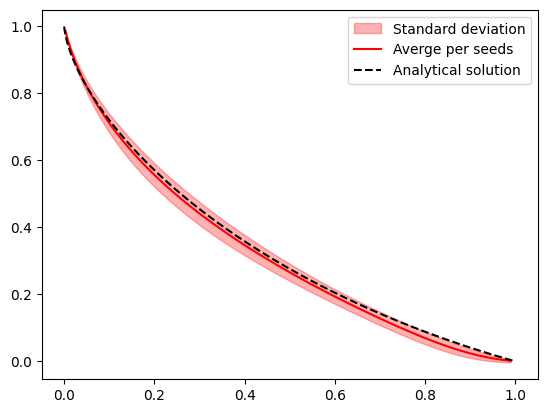

In [ ]:
avg_u = np.mean(uu, axis = 2)

# plt.plot(avg_u[:,0], avg_u[:,1], 'r', label="Averge per seeds")



# plt.plot(uu[:,0,:], uu[:,1,:], 'y--')
std_uu = np.std(uu, axis=2)
plt.fill_between(avg_u[:,0], avg_u[:,1] - std_uu[:,1], avg_u[:,1] + std_uu[:,1], color='r', alpha=0.3, label="Standard deviation")
plt.plot(avg_u[:,0], avg_u[:,1], 'r', label="Averge per seeds")


r = 0.5729
theta = np.linspace(0, np.arccos(1 - 1 / r), 101)
x = r * (theta - np.sin(theta))
y = 1 - r * (1 - np.cos(theta))
plt.plot(x, y, 'k--', label = 'Analytical solution')

plt.legend()
plt.show()
